In [116]:
# !mkdir dcgan
# !mkdir dcgan/tf
# !mkdir dcgan/tf/images
# !mkdir dcgan/tf/training_checkpoints

In [117]:
#import the required packages
import os
import time
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
from numpy import random

%matplotlib inline

In [118]:
img_height, img_width = 64, 64
batch_size = 128
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'anime-data',
  labels = 'inferred',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 11526 files belonging to 1 classes.


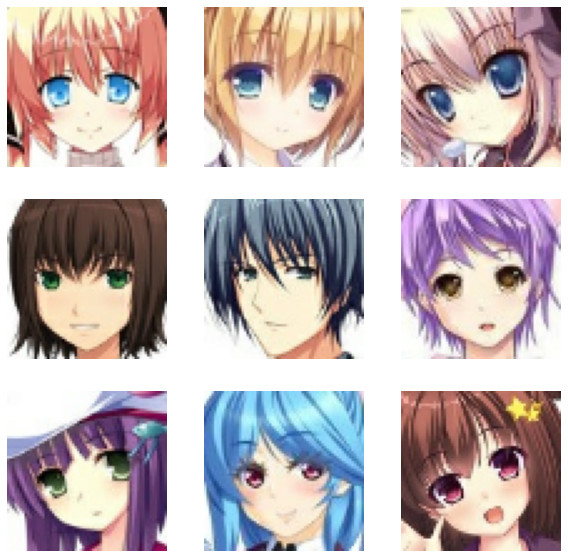

In [17]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [18]:
tf.data.experimental.AUTOTUNE

-1

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) 

normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))

In [8]:
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

-1.0 1.0


In [9]:
noise_dim = (1,1,100)

In [10]:
def generator():
    
    inputs = keras.Input(shape=(1, 1, 100), name='input_layer')
    x = layers.Conv2DTranspose(64 * 8, kernel_size=4, strides= 4, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1')(inputs)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.ReLU(name='relu_1')(x)
    
    x = layers.Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.ReLU(name='relu_2')(x)
    
    x = layers.Conv2DTranspose(64 * 2, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3')(x)
    x = layers.ReLU(name='relu_3')(x)
  

    x = layers.Conv2DTranspose(64 * 1, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4')(x)
    x = layers.ReLU(name='relu_4')(x)
    
    outputs = layers.Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, activation='tanh', name='conv_transpose_5')(x)
   
    model = tf.keras.Model(inputs, outputs, name="Generator")
    return model

In [11]:
generator = generator()

In [12]:
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 1, 100)]       0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 4, 4, 512)         819200    
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 4, 4, 512)         2048      
_________________________________________________________________
relu_1 (ReLU)                (None, 4, 4, 512)         0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 8, 8, 256)         2097152   
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 8, 8, 256)         1024      
_________________________________________________________________
relu_2 (ReLU)                (None, 8, 8, 256)         0 

In [13]:
generator.save('dcgan_gen.h5')

In [14]:
def discriminator():
    
    inputs = keras.Input(shape=(64, 64, 3), name='input_layer')
    x = layers.Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_1')(inputs)
    x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
    
    x = layers.Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_2')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
    
    x = layers.Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_3')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_3')(x)
  

    x = layers.Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_4')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_4')(x)
    
    outputs = layers.Conv2D(1, 4, 4,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, activation='sigmoid', name='conv_5')(x)
    
    outputs = layers.Flatten()(outputs)
   
    model = tf.keras.Model(inputs, outputs, name="Discriminator")
    return model

In [15]:
discriminator = discriminator()

In [16]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 32, 32, 64)        3072      
_________________________________________________________________
leaky_relu_1 (LeakyReLU)     (None, 32, 32, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 128)       131072    
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_relu_2 (LeakyReLU)     (None, 16, 16, 128)       0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 8, 8, 256)       

In [17]:
discriminator.save('dcgan_disc.h5')

In [18]:
BATCH_SIZE=128
latent_dim = 100

In [19]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [20]:
def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    tf.print('Gen_loss:',gen_loss)
    return gen_loss

In [21]:
def discriminator_loss_real(label, output):
    disc_loss = binary_cross_entropy(label, output)
    tf.print('Disc_real_loss:',disc_loss)
    return disc_loss

In [22]:
def discriminator_loss_fake(label, output):
    disc_loss = binary_cross_entropy(label, output)
    tf.print('Disc_fake_loss:',disc_loss)
    return disc_loss

In [23]:
learning_rate = 0.0002 
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

In [24]:
num_examples_to_generate = 25
# We will reuse this seed overtime to visualize progress
seed = tf.random.normal([num_examples_to_generate, 1, 1, latent_dim])

In [25]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # noise vector sampled from normal distribution
    noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])

    # Train Discriminator with real labels
    with tf.GradientTape() as disc_tape1:
        generated_images = generator(noise, training=True)

        
        real_output = discriminator(images, training=True)
        real_targets = tf.ones_like(real_output)
        disc_loss1 = discriminator_loss(real_targets, real_output)
        
    # gradient calculation for discriminator for real labels    
    gradients_of_disc1 = disc_tape1.gradient(disc_loss1, discriminator.trainable_variables)
    
    # parameters optimization for discriminator for real labels   
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc1,\
    discriminator.trainable_variables))
    
    # Train Discriminator with fake labels
    with tf.GradientTape() as disc_tape2:
        fake_output = discriminator(generated_images, training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)
    # gradient calculation for discriminator for fake labels 
    gradients_of_disc2 = disc_tape2.gradient(disc_loss2, discriminator.trainable_variables)
    
    
    # parameters optimization for discriminator for fake labels        
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc2,\
    discriminator.trainable_variables))
    
    # Train Generator with real labels
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)

    # gradient calculation for generator for real labels     
    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # parameters optimization for generator for real labels
    generator_optimizer.apply_gradients(zip(gradients_of_gen,\
    generator.trainable_variables))   

In [26]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        D_loss_list, G_loss_list = [], []
        for image_batch in dataset:
            i += 1
            train_step(image_batch)
        print(epoch)        
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                              epoch + 1,
                              seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            generator.save_weights('dcgan/tf/training_weights/gen_'+ str(epoch)+'.h5')
            discriminator.save_weights('dcgan/tf/training_weights/disc_'+ str(epoch)+'.h5')    
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)

In [27]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = (predictions[i, :, :, :] + 1 ) * 127.5
        pred = np.array(pred)  
        plt.imshow(pred.astype(np.uint8))
        plt.axis('off')

    plt.savefig('dcgan/tf/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()



Epoch:1
Disc_real_loss: 0.693087935
Disc_fake_loss: 0.695658326
Gen_loss: 0.691865087
Disc_real_loss: 0.562276244
Disc_fake_loss: 0.695513129
Gen_loss: 0.691781819
Disc_real_loss: 0.409250349
Disc_fake_loss: 0.695874572
Gen_loss: 0.691604733
Disc_real_loss: 0.202489763
Disc_fake_loss: 0.696032
Gen_loss: 0.691950858
Disc_real_loss: 0.0689653382
Disc_fake_loss: 0.695766389
Gen_loss: 0.692647576
Disc_real_loss: 0.0167896897
Disc_fake_loss: 0.695490301
Gen_loss: 0.693493247
Disc_real_loss: 0.00315744
Disc_fake_loss: 0.695774674
Gen_loss: 0.694467425
Disc_real_loss: 0.0030706008
Disc_fake_loss: 0.696734726
Gen_loss: 0.695266426


Epoch:2
Disc_real_loss: 0.00374901295
Disc_fake_loss: 0.70101738
Gen_loss: 0.694793224
Disc_real_loss: 0.00295816455
Disc_fake_loss: 0.706693411
Gen_loss: 0.695807
Disc_real_loss: 0.00413466
Disc_fake_loss: 0.705416262
Gen_loss: 0.70746994
Disc_real_loss: 0.00733540487
Disc_fake_loss: 0.680912495
Gen_loss: 0.7404266
Disc_real_loss: 0.0097359959
Disc_fake_loss: 0.

Disc_fake_loss: 0.0151496343
Gen_loss: 5.4015193
Disc_real_loss: 0.00364783569
Disc_fake_loss: 0.014428786
Gen_loss: 5.51200104


Epoch:14
Disc_real_loss: 0.0132430512
Disc_fake_loss: 0.0186450239
Gen_loss: 5.37938452
Disc_real_loss: 0.00466023665
Disc_fake_loss: 0.022705324
Gen_loss: 5.43276215
Disc_real_loss: 0.00496430276
Disc_fake_loss: 0.0135789383
Gen_loss: 5.61362267
Disc_real_loss: 0.0138848796
Disc_fake_loss: 0.0273811668
Gen_loss: 5.65184546
Disc_real_loss: 0.0212809276
Disc_fake_loss: 0.0346251428
Gen_loss: 5.89430237
Disc_real_loss: 0.00338655384
Disc_fake_loss: 0.00493837427
Gen_loss: 6.30556583
Disc_real_loss: 0.016180804
Disc_fake_loss: 0.0136118829
Gen_loss: 5.32419348
Disc_real_loss: 0.0106820362
Disc_fake_loss: 0.0219397731
Gen_loss: 5.68819714


Epoch:15
Disc_real_loss: 0.0130177233
Disc_fake_loss: 0.0160099566
Gen_loss: 5.75583887
Disc_real_loss: 0.00507315714
Disc_fake_loss: 0.0135188308
Gen_loss: 6.05922699
Disc_real_loss: 0.0460077152
Disc_fake_loss: 0.0838323608

<ipython-input-27-653d7e62164b>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,10))




Epoch:22
Disc_real_loss: 0.112364128
Disc_fake_loss: 0.10479711
Gen_loss: 3.89118385
Disc_real_loss: 0.0719709694
Disc_fake_loss: 0.0696179792
Gen_loss: 3.88719678
Disc_real_loss: 0.08099325
Disc_fake_loss: 0.0899735391
Gen_loss: 3.82001114
Disc_real_loss: 0.143666416
Disc_fake_loss: 0.108059064
Gen_loss: 3.84689331
Disc_real_loss: 0.0504045412
Disc_fake_loss: 0.0588985719
Gen_loss: 3.99337888
Disc_real_loss: 0.157753572
Disc_fake_loss: 0.0907167643
Gen_loss: 3.90688658
Disc_real_loss: 0.0476151295
Disc_fake_loss: 0.0556127876
Gen_loss: 4.10094643
Disc_real_loss: 0.124013305
Disc_fake_loss: 0.0775240511
Gen_loss: 3.91446829


Epoch:23
Disc_real_loss: 0.0701113865
Disc_fake_loss: 0.100546375
Gen_loss: 4.43049717
Disc_real_loss: 0.0718408227
Disc_fake_loss: 0.0295295082
Gen_loss: 4.40446186
Disc_real_loss: 0.112359352
Disc_fake_loss: 0.126767755
Gen_loss: 4.60789537
Disc_real_loss: 0.0555746779
Disc_fake_loss: 0.0308566503
Gen_loss: 4.62793684
Disc_real_loss: 0.0833137929
Disc_fake_los



Epoch:35
Disc_real_loss: 0.020556204
Disc_fake_loss: 0.118853077
Gen_loss: 6.15066814
Disc_real_loss: 0.214436784
Disc_fake_loss: 0.0472478718
Gen_loss: 4.88404179
Disc_real_loss: 0.0209046379
Disc_fake_loss: 0.187391981
Gen_loss: 7.4624958
Disc_real_loss: 0.0561274067
Disc_fake_loss: 0.00126995007
Gen_loss: 8.13769913
Disc_real_loss: 0.108574823
Disc_fake_loss: 0.0206494629
Gen_loss: 4.99266386
Disc_real_loss: 0.0293585323
Disc_fake_loss: 0.161319211
Gen_loss: 6.61701488
Disc_real_loss: 0.0208729506
Disc_fake_loss: 0.00596876256
Gen_loss: 6.59009409
Disc_real_loss: 0.115031622
Disc_fake_loss: 0.0700518042
Gen_loss: 4.66827965


Epoch:36
Disc_real_loss: 0.0164534915
Disc_fake_loss: 0.192344636
Gen_loss: 7.18315077
Disc_real_loss: 0.670479476
Disc_fake_loss: 0.503989935
Gen_loss: 7.98554182
Disc_real_loss: 0.141027123
Disc_fake_loss: 0.000622936059
Gen_loss: 8.69360256
Disc_real_loss: 0.0858493596
Disc_fake_loss: 0.00432836125
Gen_loss: 6.04349661
Disc_real_loss: 0.0242966339
Disc_fak

Disc_real_loss: 0.131716371
Disc_fake_loss: 0.0149427317
Gen_loss: 5.46936703


Epoch:48
Disc_real_loss: 0.115565948
Disc_fake_loss: 0.091506429
Gen_loss: 4.42388725
Disc_real_loss: 0.0753757507
Disc_fake_loss: 0.189384937
Gen_loss: 5.8775835
Disc_real_loss: 0.191934794
Disc_fake_loss: 0.0317662656
Gen_loss: 4.76271057
Disc_real_loss: 0.223227784
Disc_fake_loss: 0.280427605
Gen_loss: 6.51945543
Disc_real_loss: 0.108627409
Disc_fake_loss: 0.00596595742
Gen_loss: 6.58865
Disc_real_loss: 0.173024535
Disc_fake_loss: 0.0861470178
Gen_loss: 4.40616894
Disc_real_loss: 0.0156796742
Disc_fake_loss: 0.120926559
Gen_loss: 5.33016109
Disc_real_loss: 0.0518407971
Disc_fake_loss: 0.0662294179
Gen_loss: 5.10571337


Epoch:49
Disc_real_loss: 0.199131042
Disc_fake_loss: 0.257284403
Gen_loss: 6.53329468
Disc_real_loss: 0.263193846
Disc_fake_loss: 0.0216603205
Gen_loss: 4.99230099
Disc_real_loss: 0.0482000858
Disc_fake_loss: 0.142633125
Gen_loss: 5.57617474
Disc_real_loss: 0.0420297161
Disc_fake_loss: 0.

Disc_fake_loss: 0.000340267783
Gen_loss: 8.30177116
Disc_real_loss: 0.00994695257
Disc_fake_loss: 0.0638716668
Gen_loss: 5.45071554


Epoch:61
Disc_real_loss: 0.00665628817
Disc_fake_loss: 0.3388789
Gen_loss: 10.7889538
Disc_real_loss: 0.121384524
Disc_fake_loss: 9.90048138e-05
Gen_loss: 11.3772964
Disc_real_loss: 0.1667137
Disc_fake_loss: 0.00473651476
Gen_loss: 6.01725578
Disc_real_loss: 0.0810132
Disc_fake_loss: 0.679490089
Gen_loss: 12.2036943
Disc_real_loss: 0.707249641
Disc_fake_loss: 0.000122134079
Gen_loss: 10.515934
Disc_real_loss: 0.20505783
Disc_fake_loss: 0.0150971571
Gen_loss: 5.25031185
Disc_real_loss: 0.0132252518
Disc_fake_loss: 0.746996641
Gen_loss: 11.7721672
Disc_real_loss: 0.184805244
Disc_fake_loss: 2.69368938e-05
Gen_loss: 13.1586075


Epoch:62
Disc_real_loss: 0.300332546
Disc_fake_loss: 0.000243509741
Gen_loss: 8.62883663
Disc_real_loss: 0.00810761284
Disc_fake_loss: 0.0562661625
Gen_loss: 5.03394175
Disc_real_loss: 0.0928529948
Disc_fake_loss: 0.771391392
Gen_lo

Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.000131228968
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.00139476918
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.000287975272
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.00113076
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.000807471341
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 2.15672262e-05
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.000206697
Disc_fake_loss: 0
Gen_loss: 15.4249458


Epoch:75
Disc_real_loss: 0.000779919326
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.0002030982
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.000119027973
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 2.10903763e-05
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.00101972162
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.00319526321
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.000240080466
Disc_fake_loss: 0
Gen

Disc_real_loss: 8.0946571e-05
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 9.56660188e-06
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.000996002345
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 7.38072777e-05
Disc_fake_loss: 0
Gen_loss: 15.4249458


Epoch:89
Disc_real_loss: 7.34123169e-05
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.000273718673
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 7.79163529e-05
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 9.29837825e-06
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.000477530586
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.00094943837
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 4.60845768e-05
Disc_fake_loss: 0
Gen_loss: 15.4249458
Disc_real_loss: 0.000296405662
Disc_fake_loss: 0
Gen_loss: 15.4249458


Epoch:90
Disc_real_loss: 7.0135291e-05
Disc_fake_loss: 9.31322686e-10
Gen_loss: 15.4214764
Disc_real_loss: 0.000291550095
Disc_fake_loss: 0
Gen_loss:

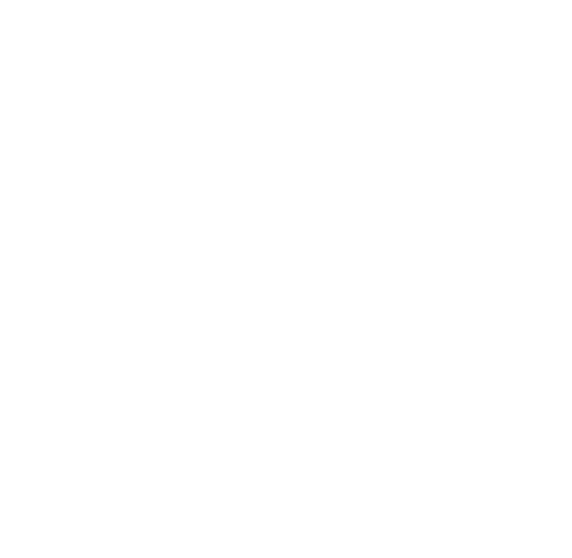

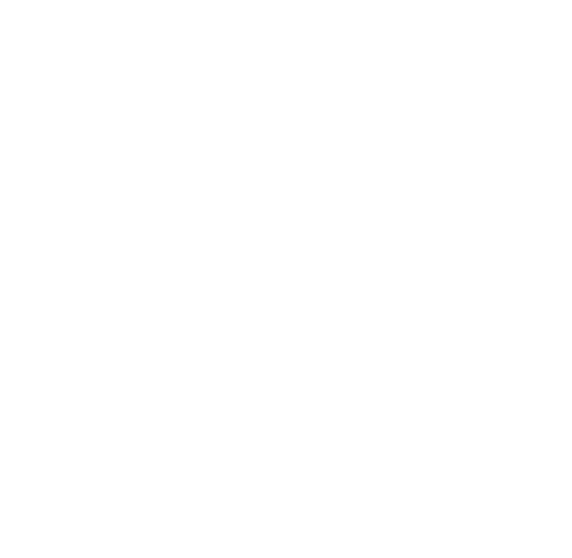

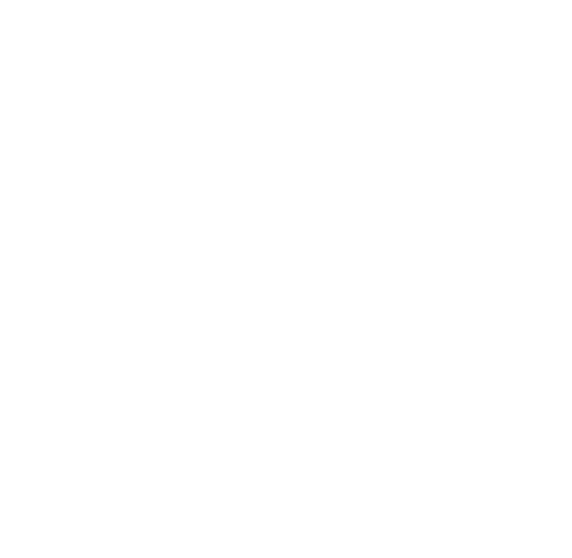

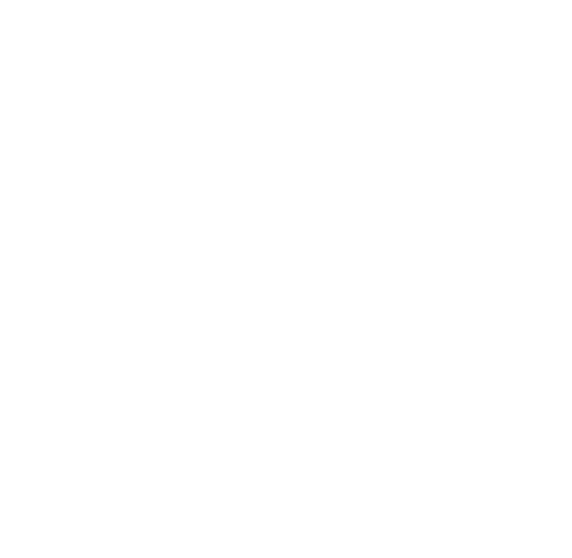

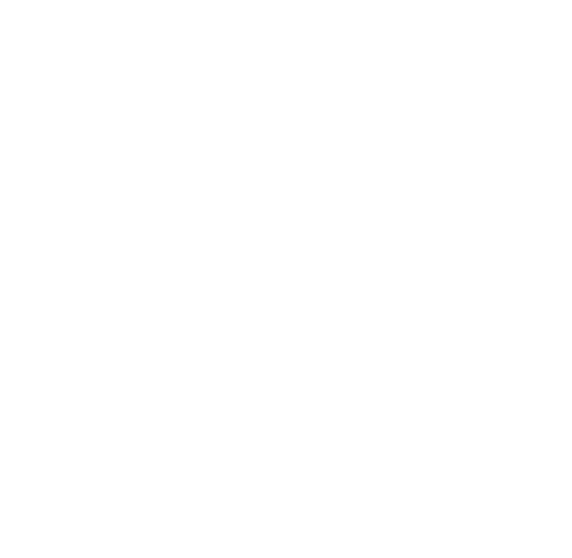

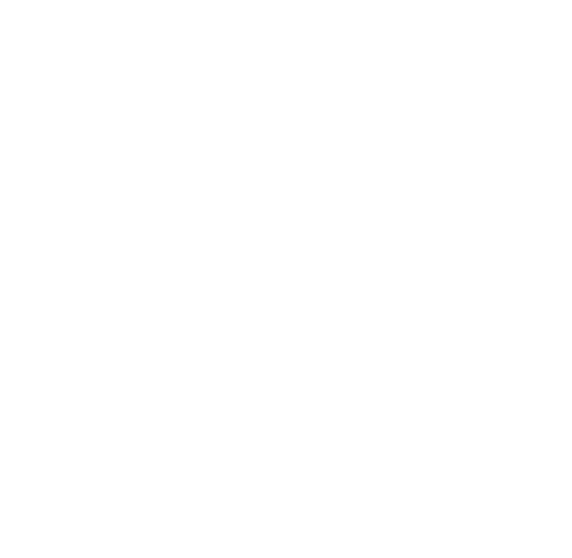

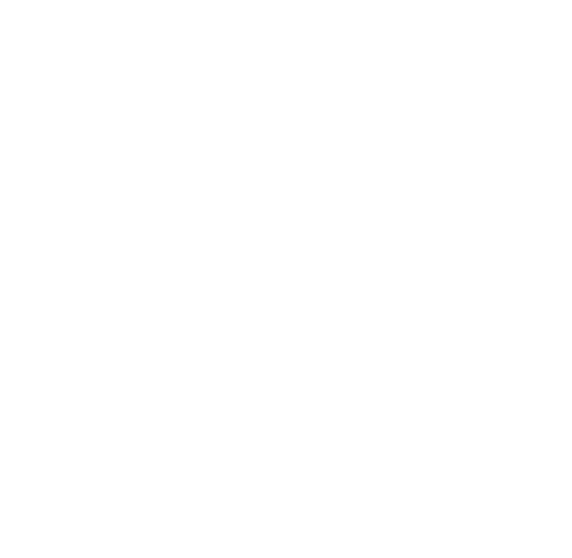

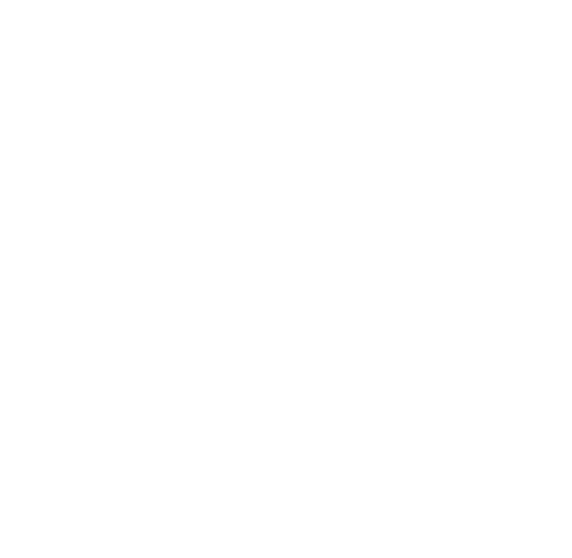

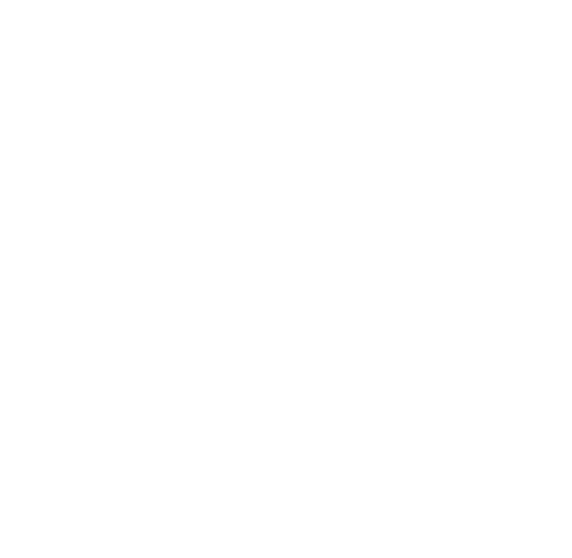

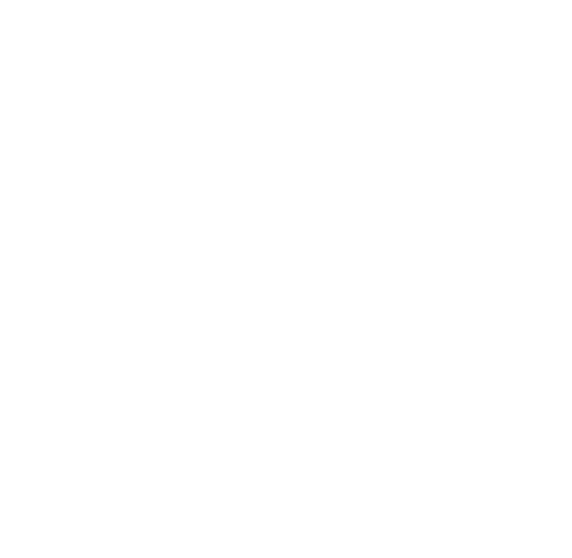

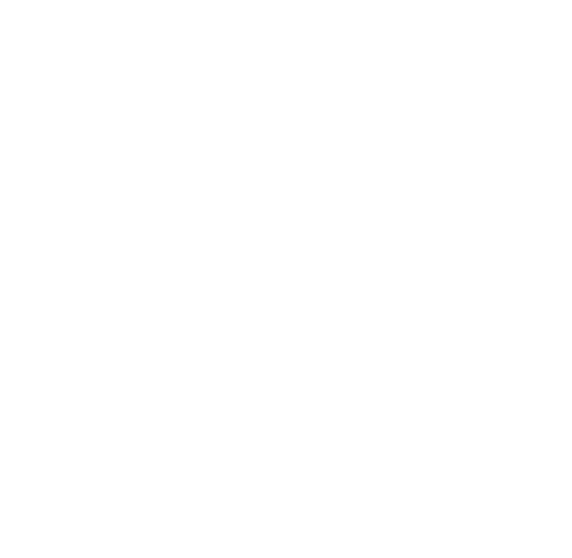

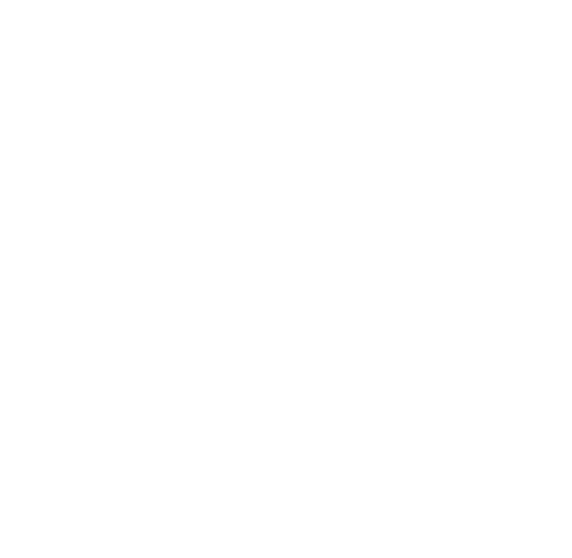

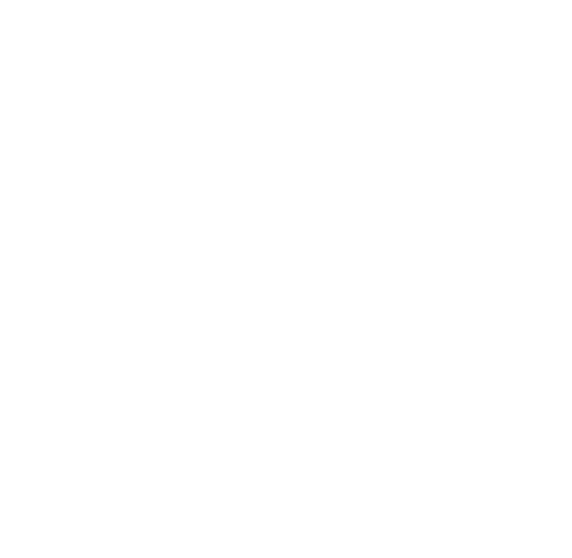

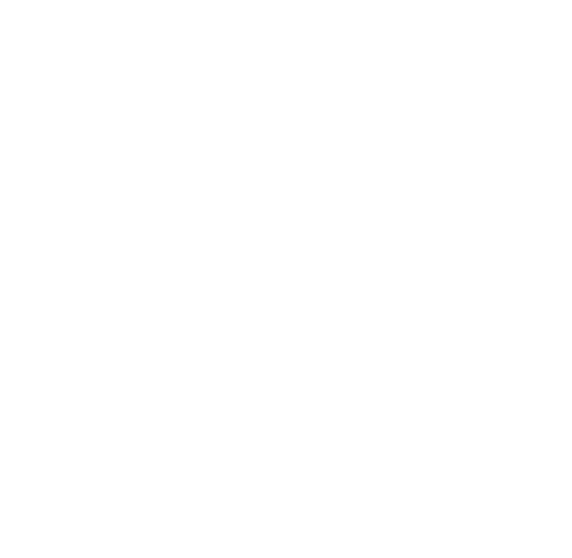

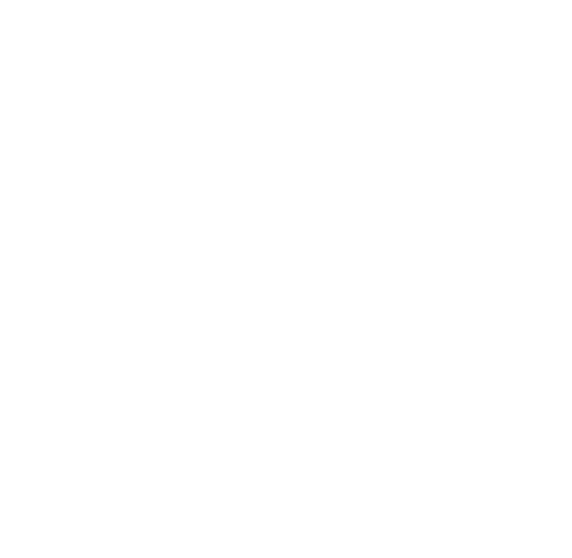

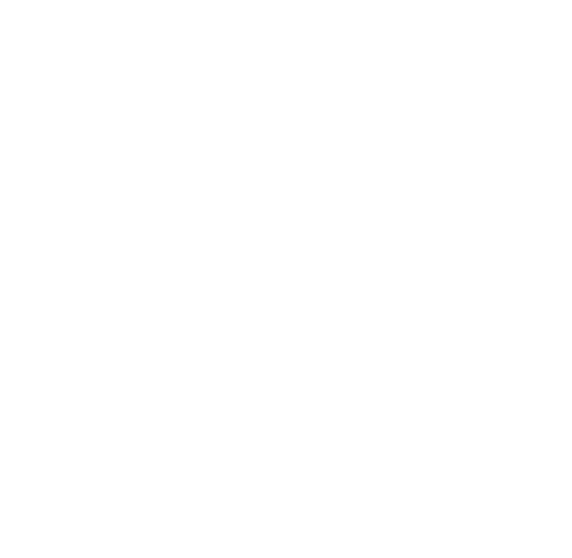

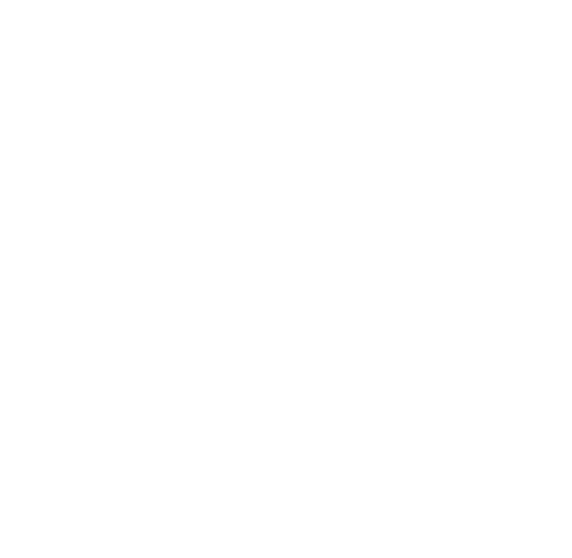

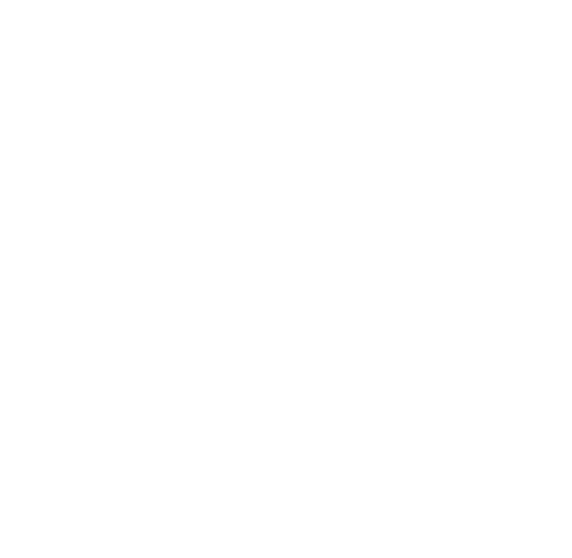

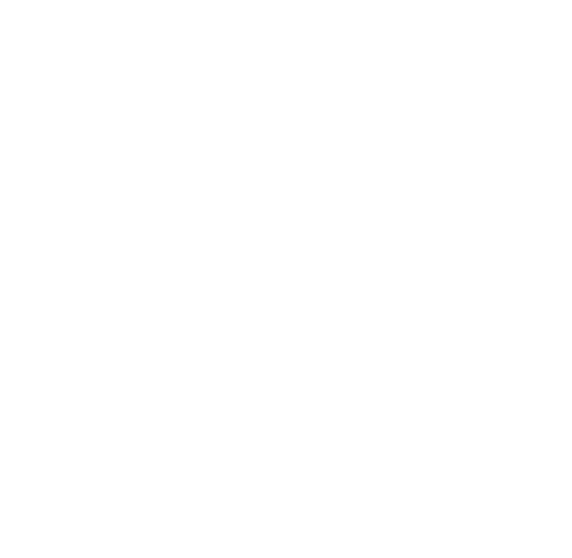

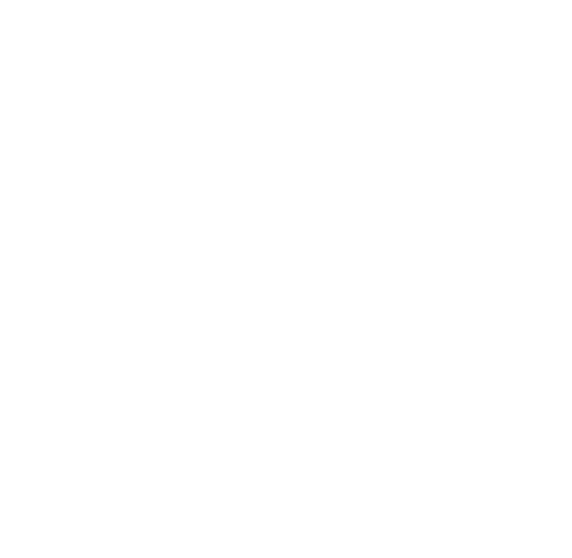

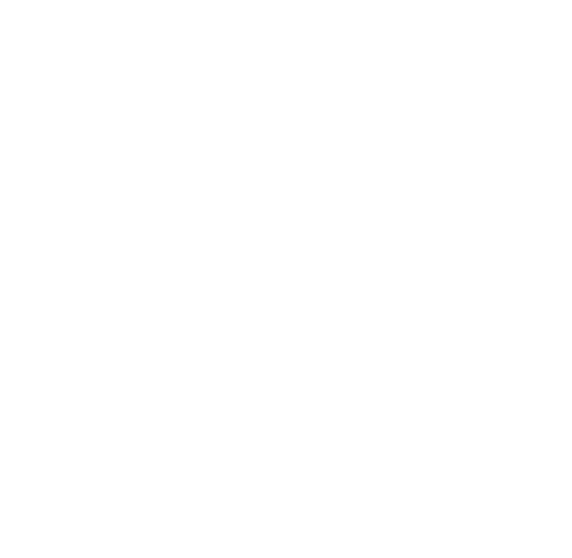

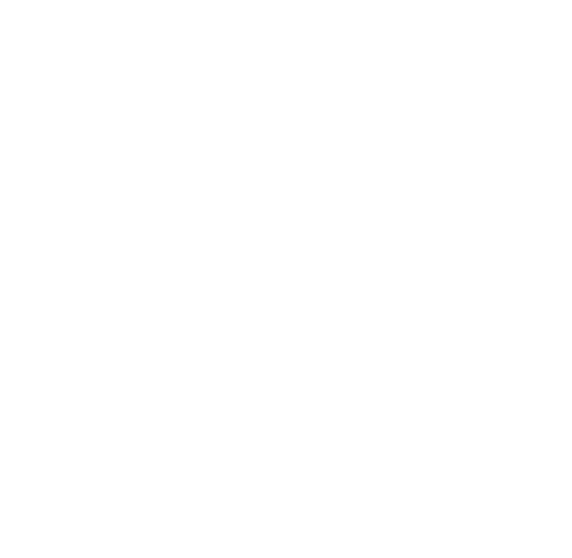

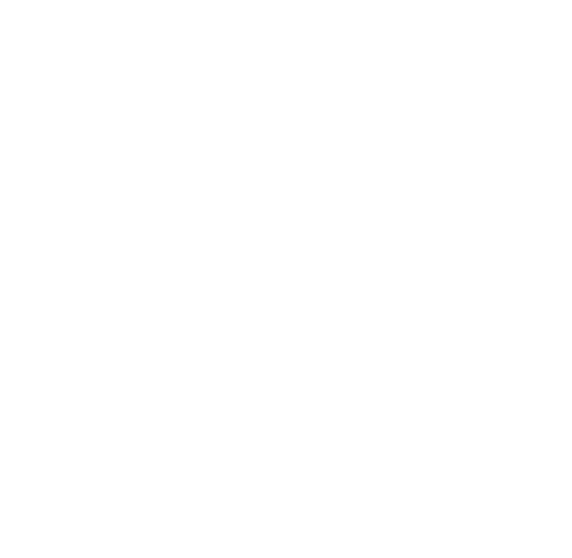

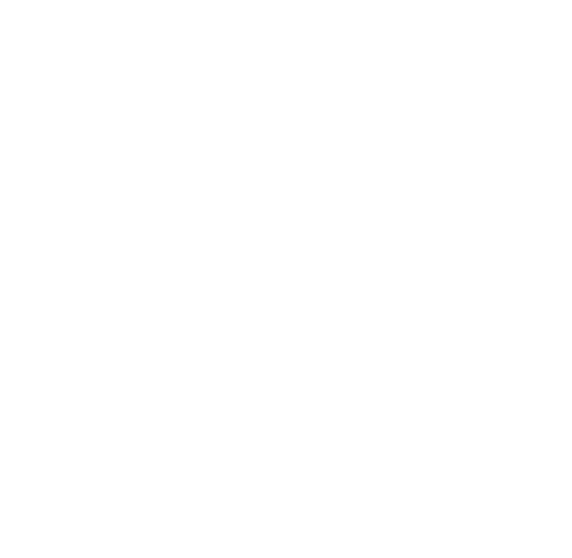

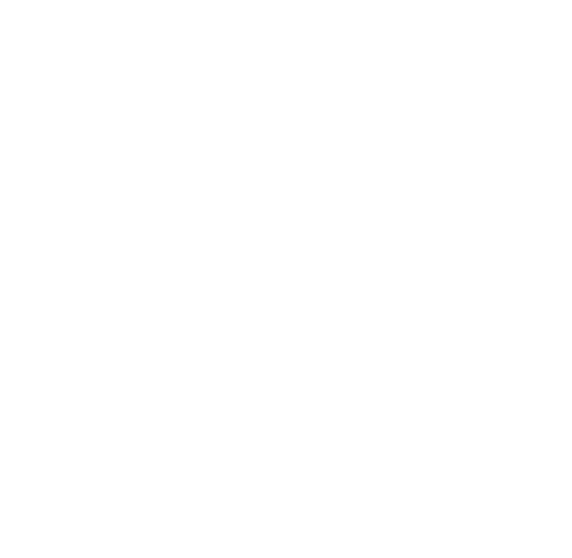

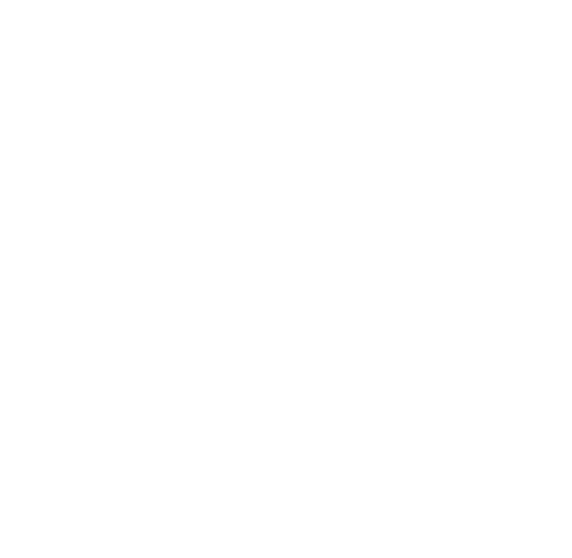

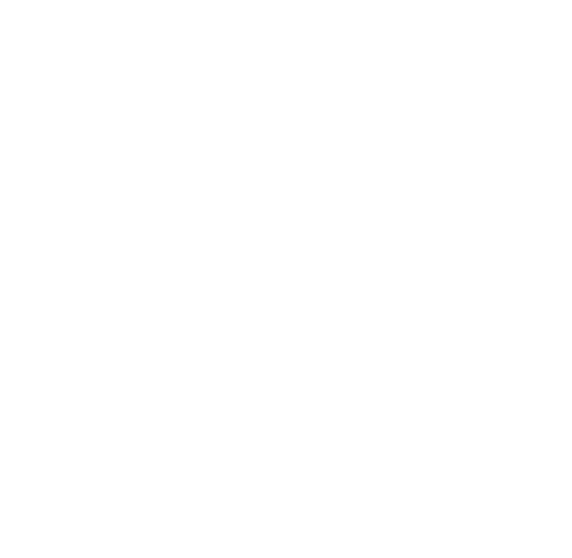

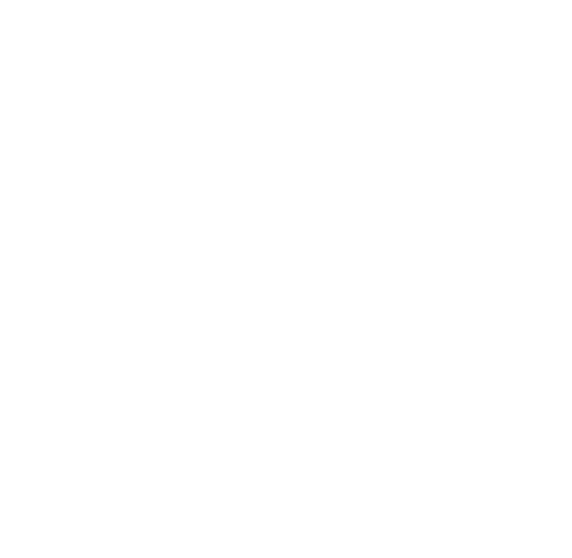

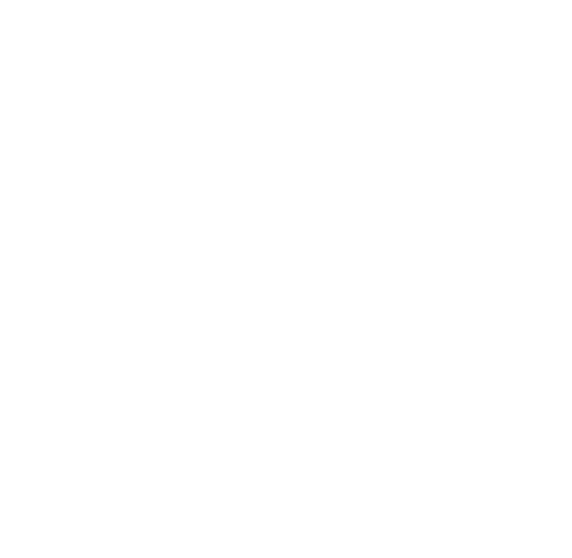

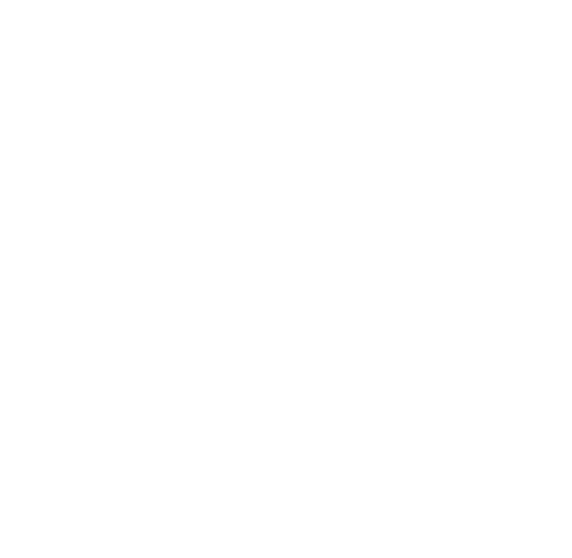

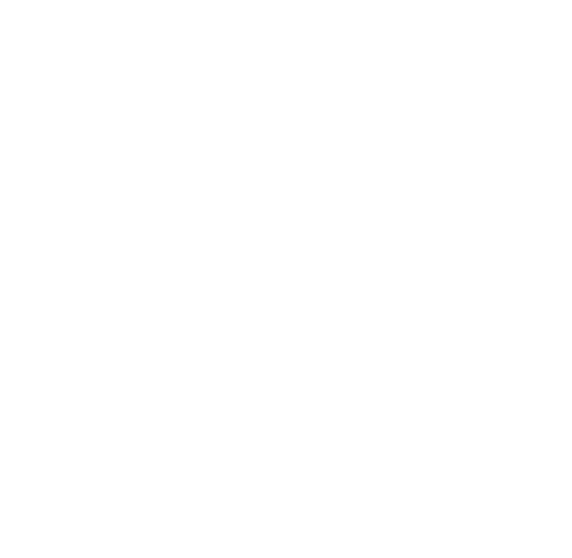

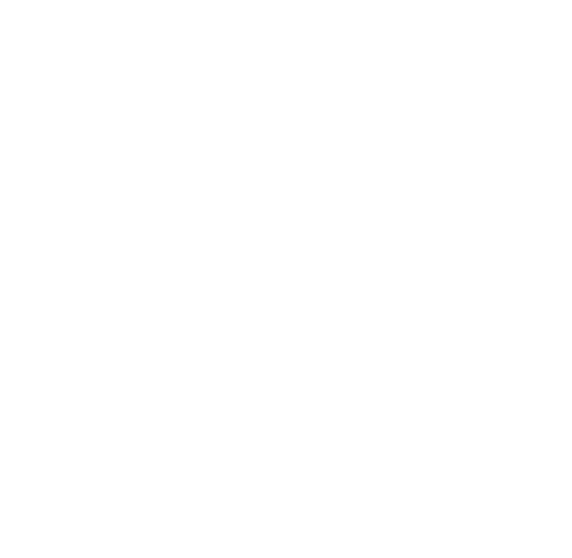

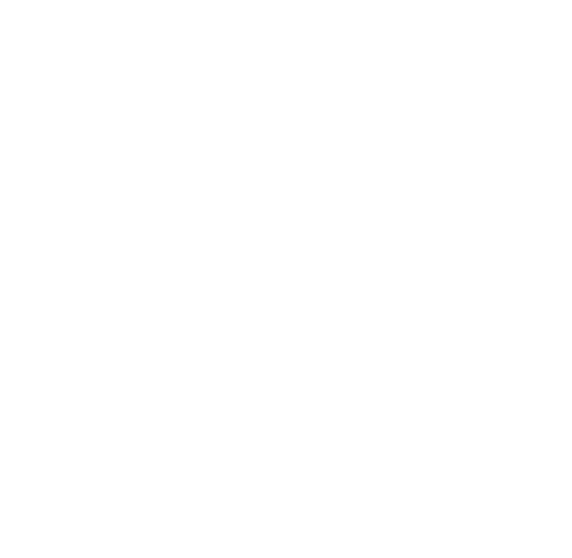

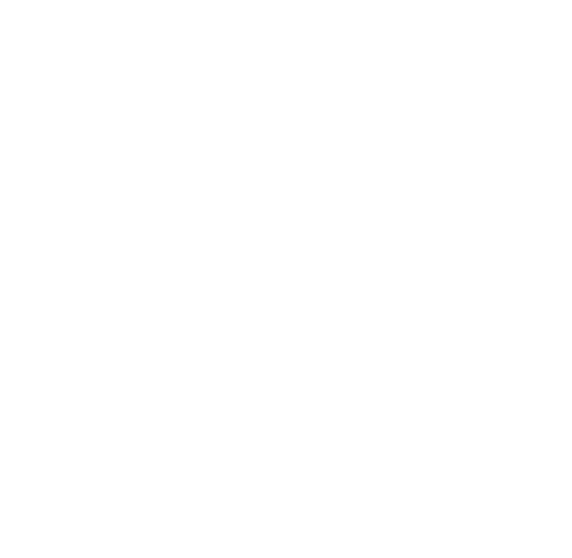

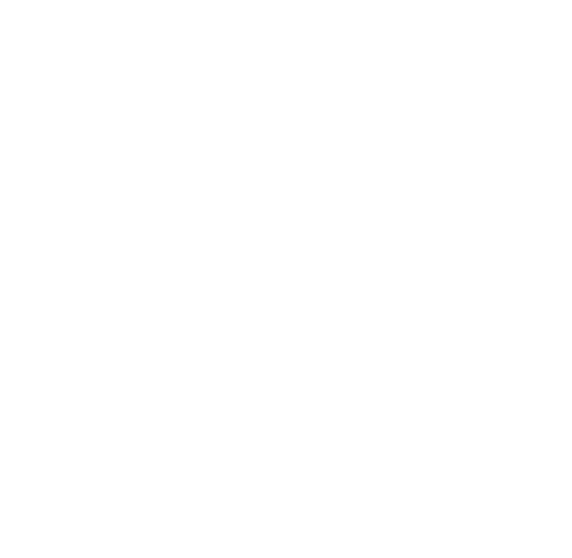

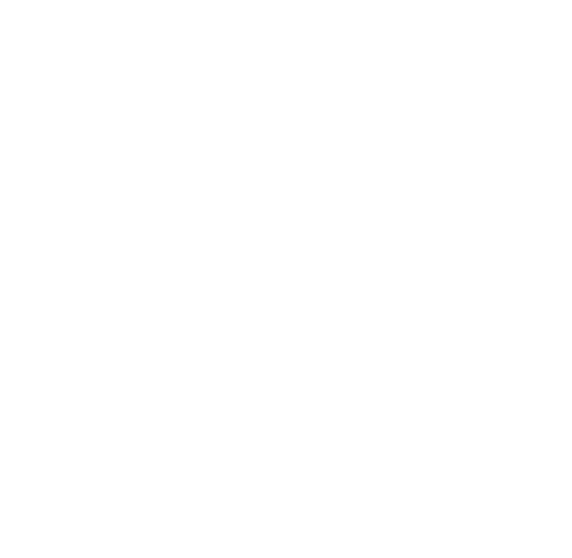

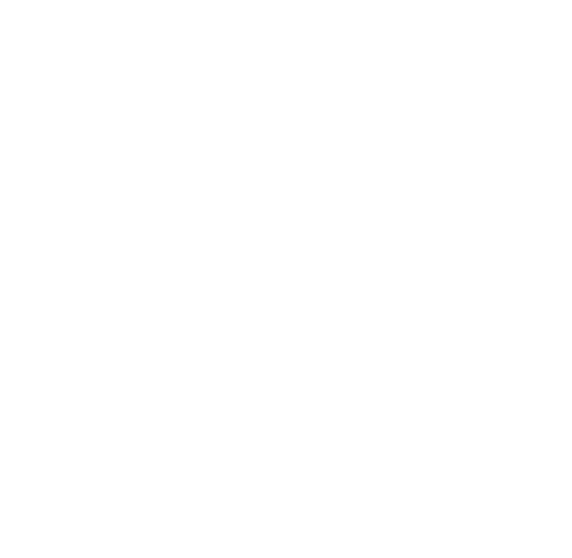

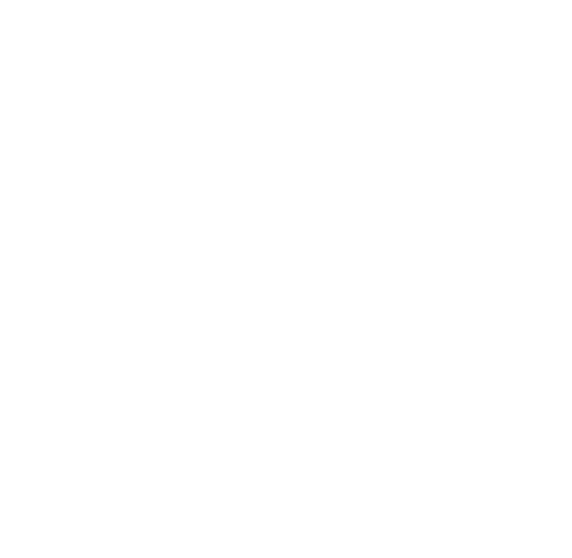

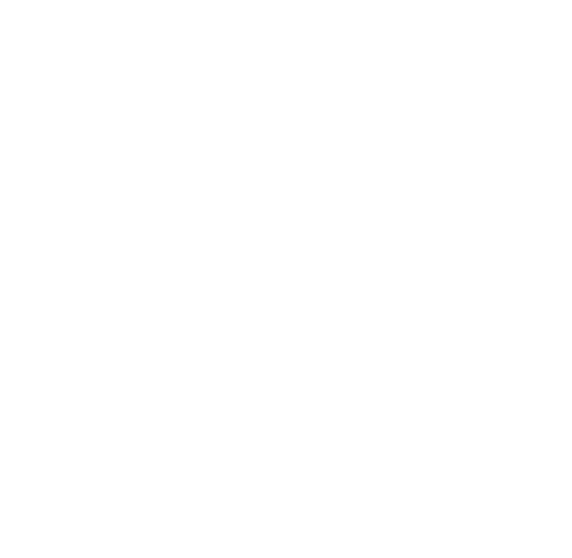

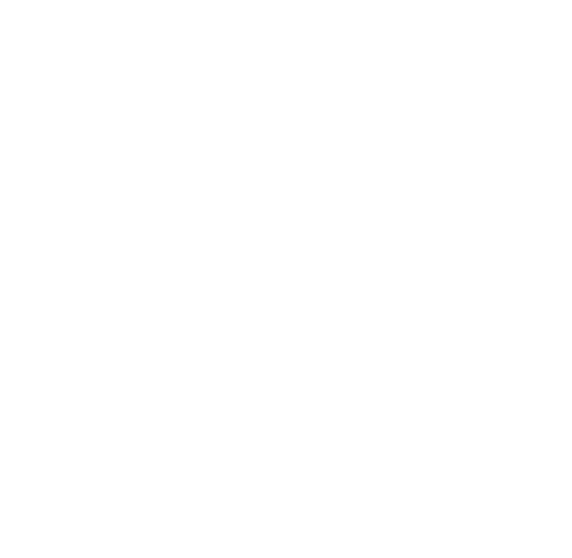

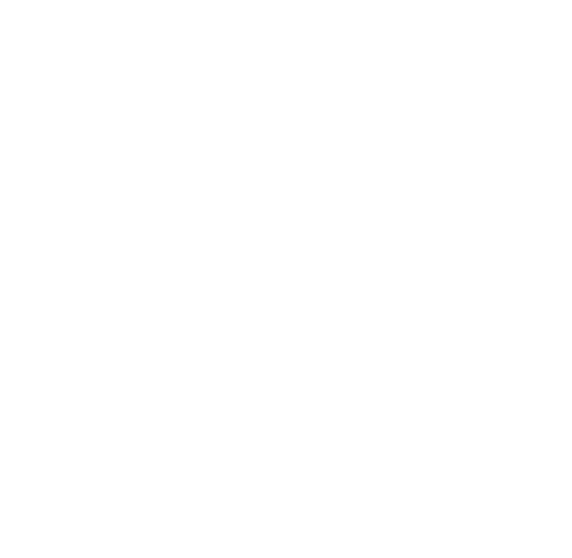

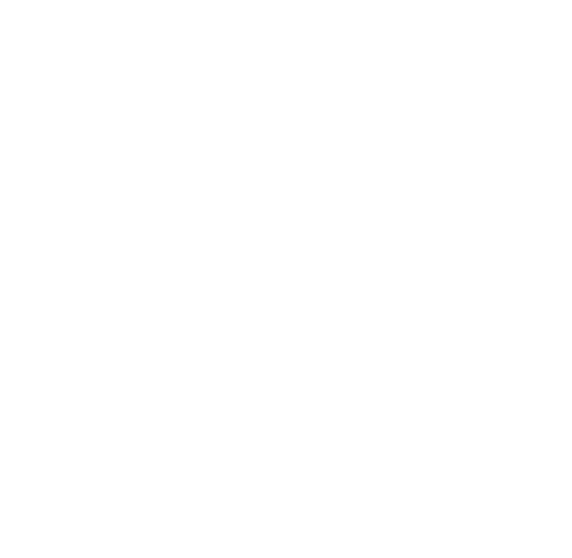

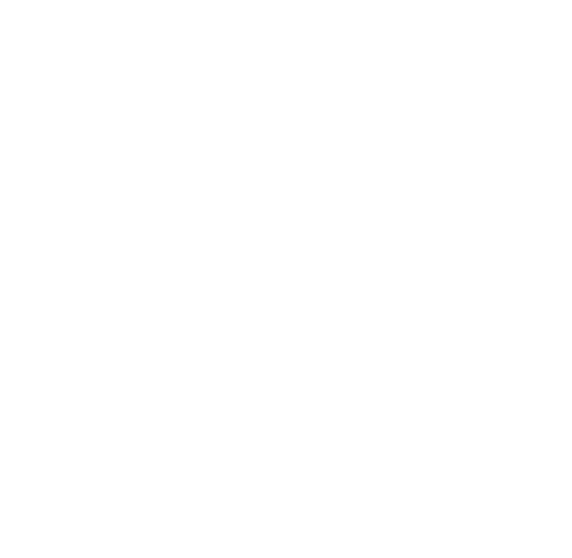

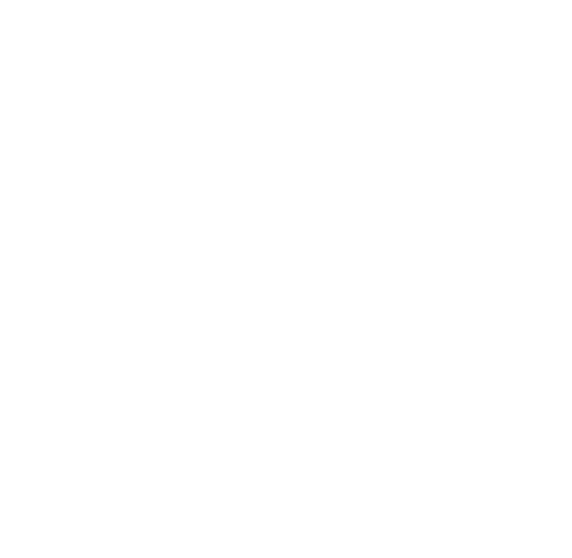

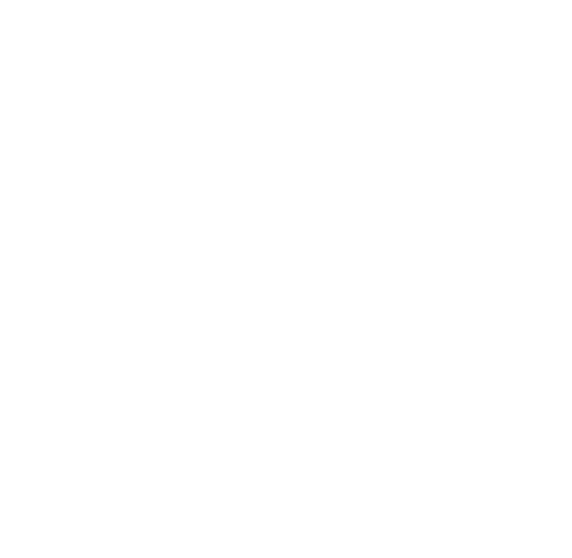

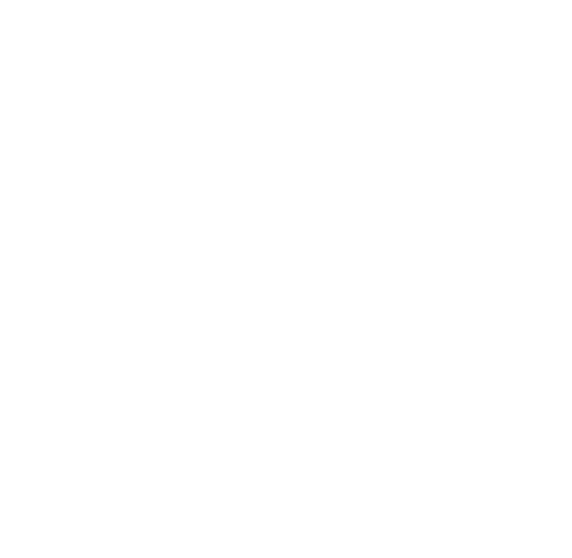

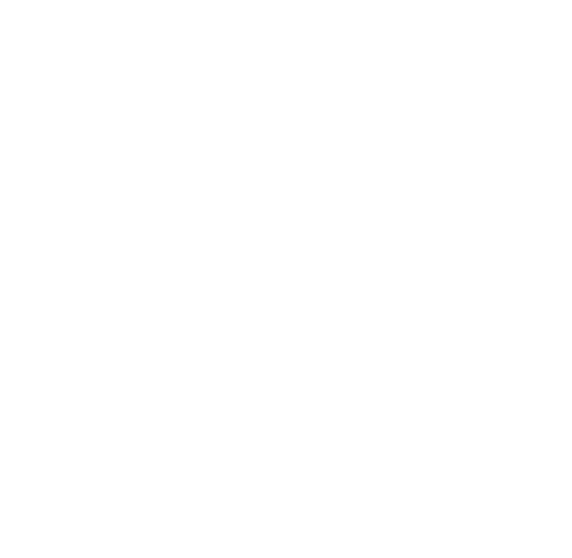

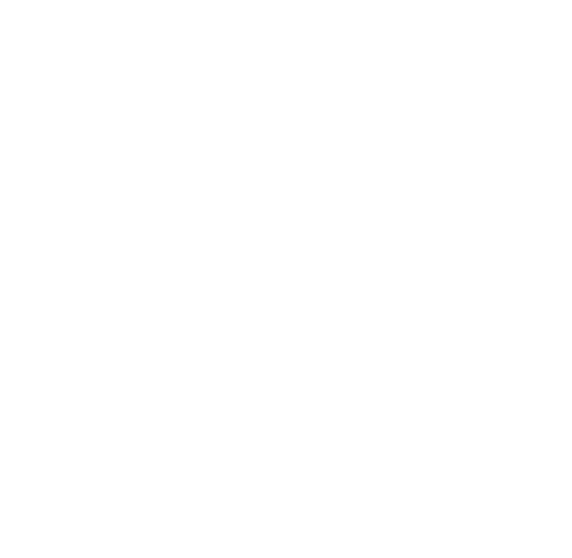

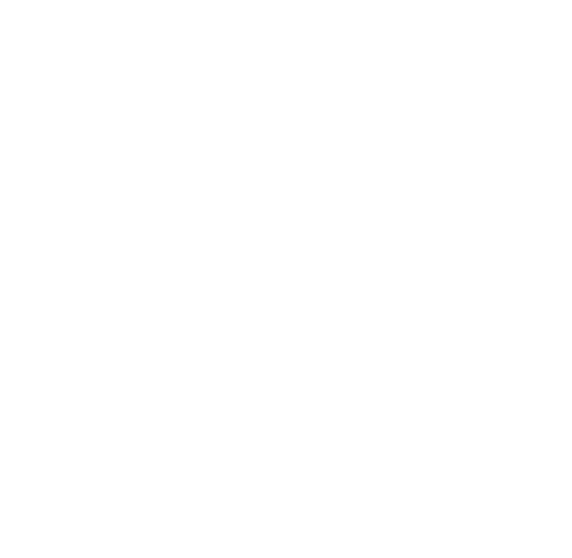

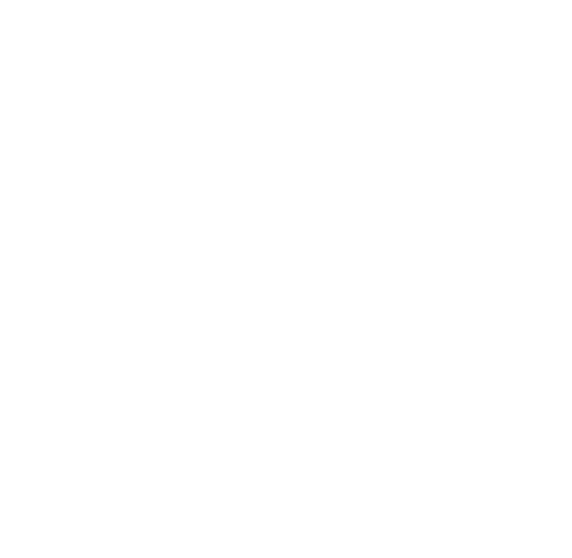

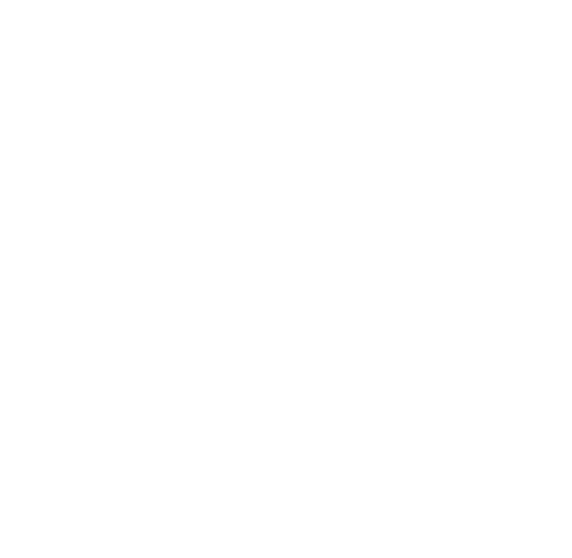

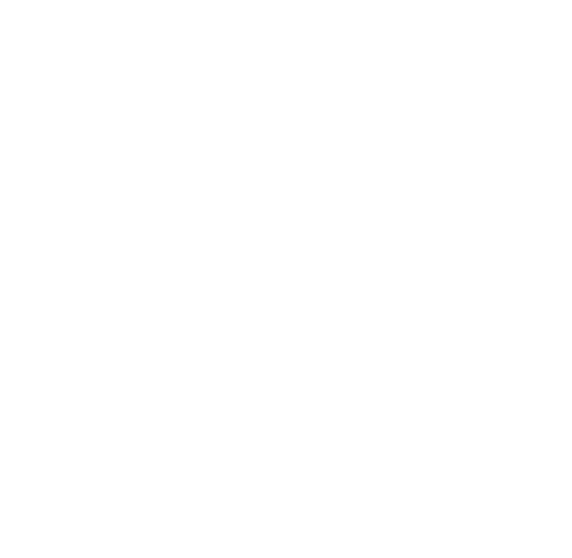

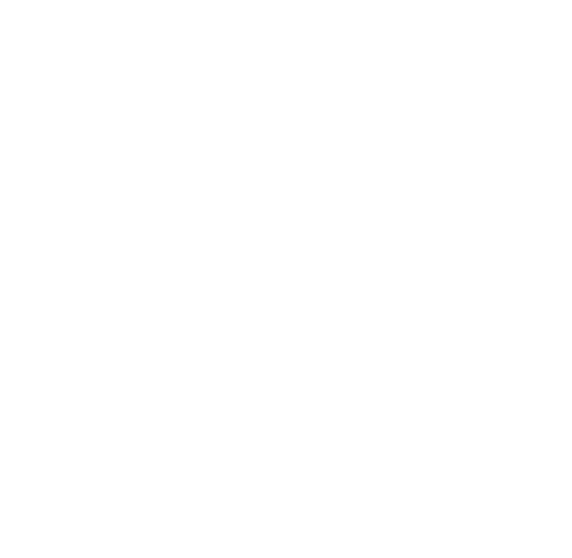

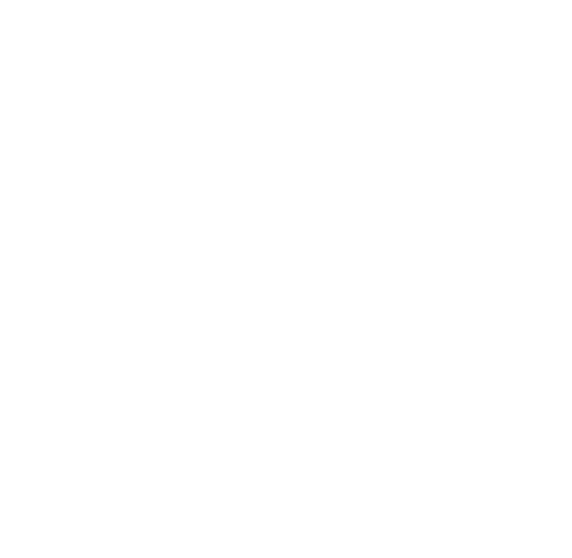

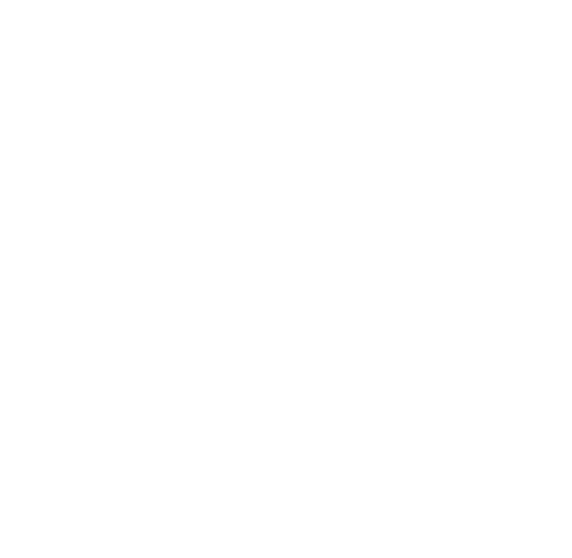

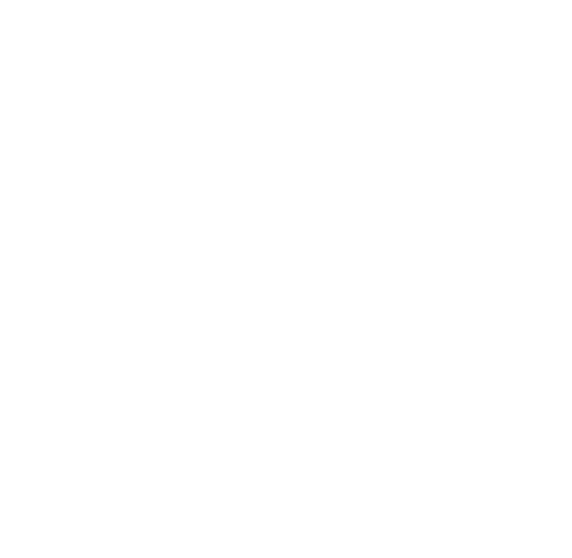

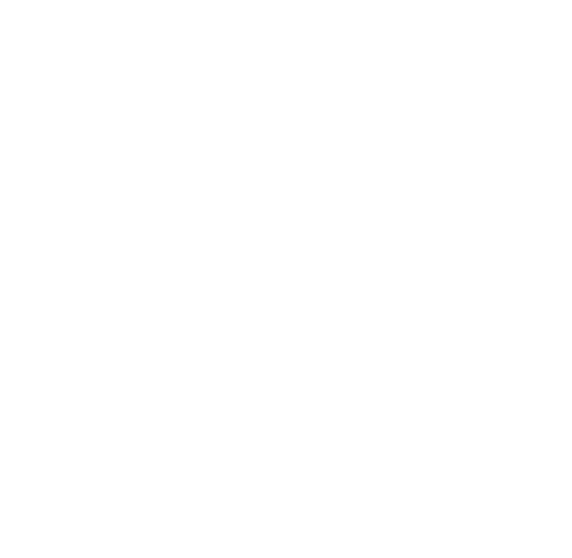

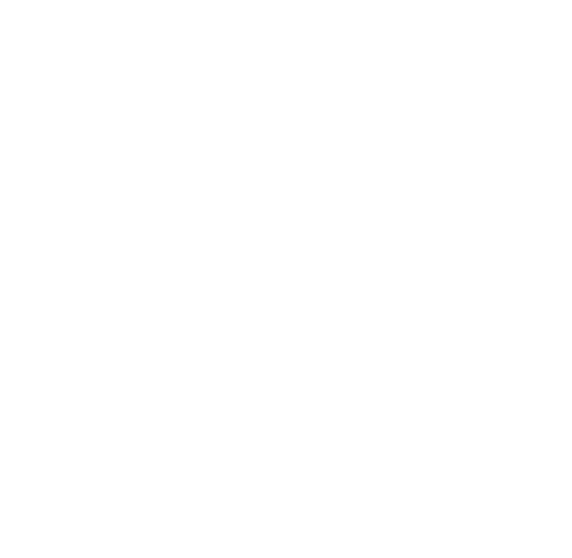

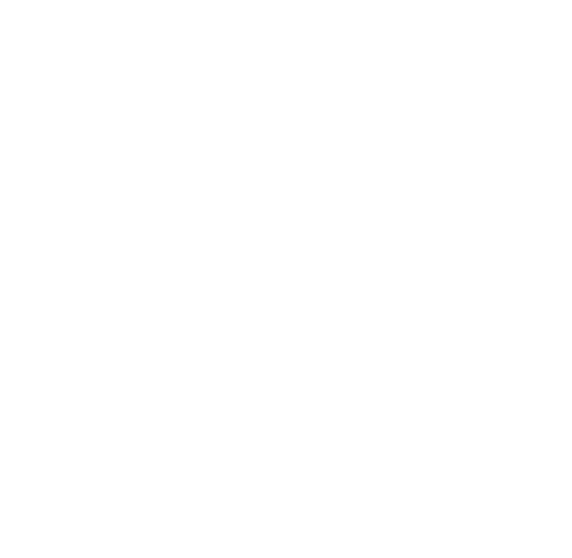

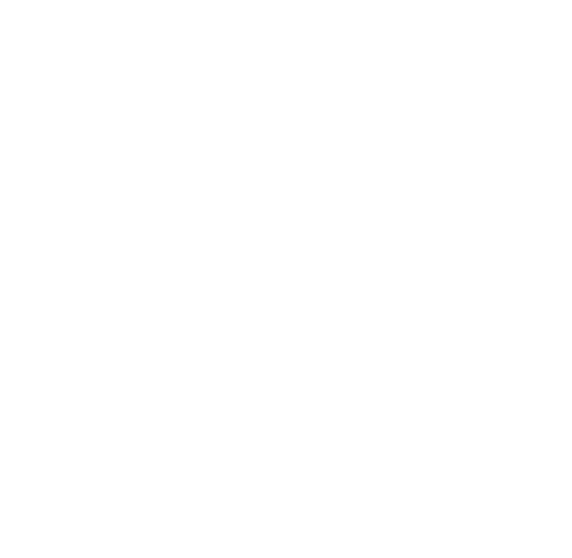

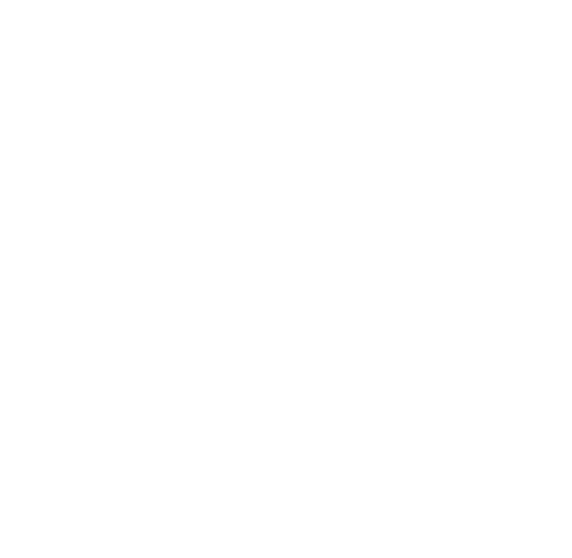

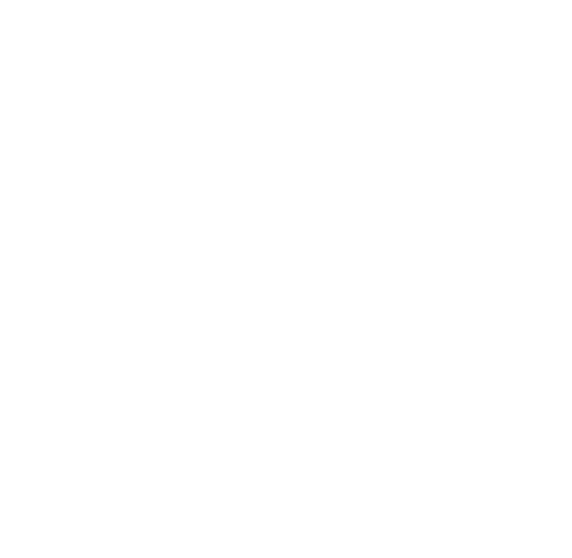

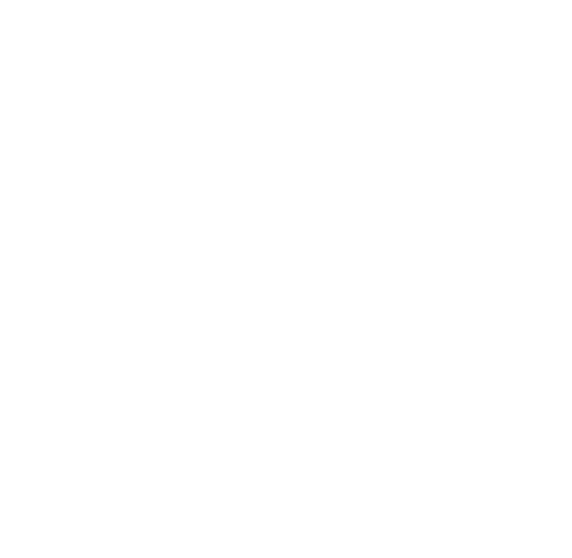

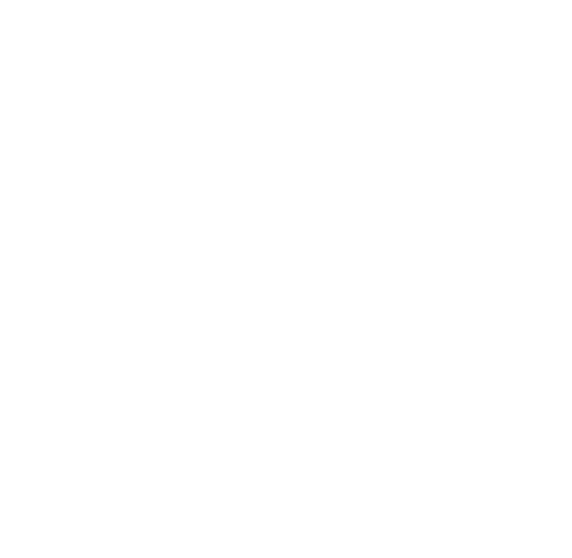

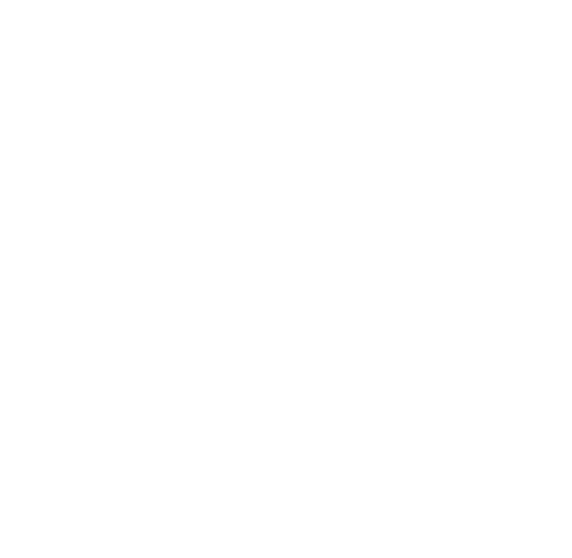

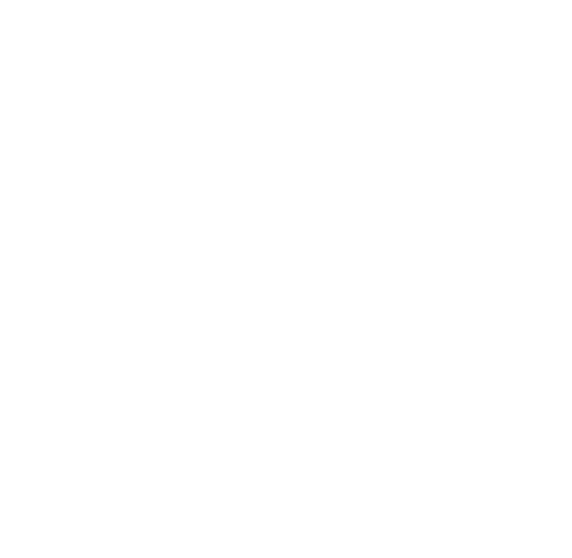

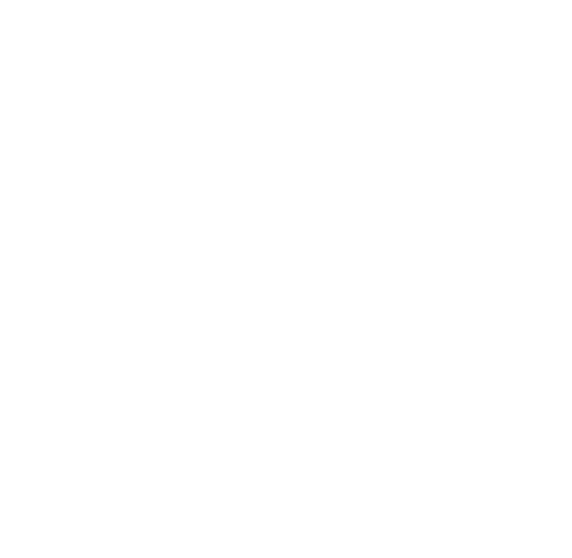

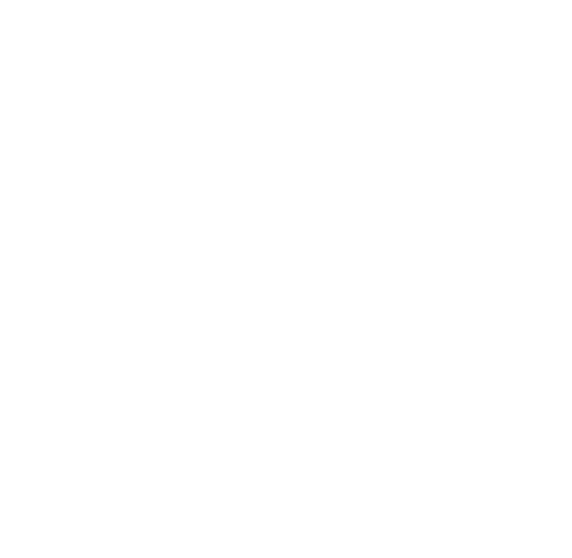

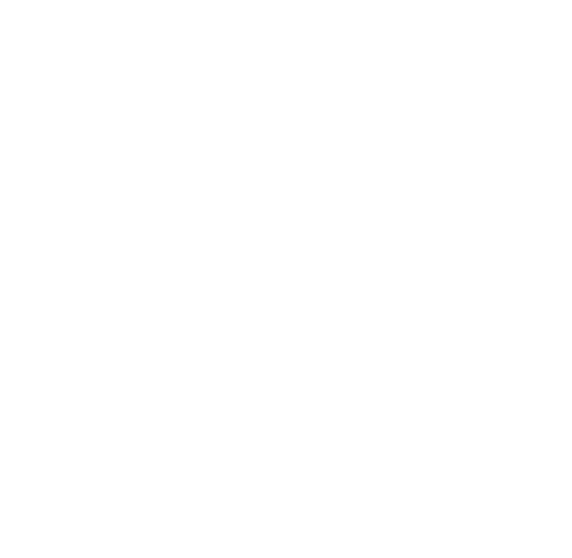

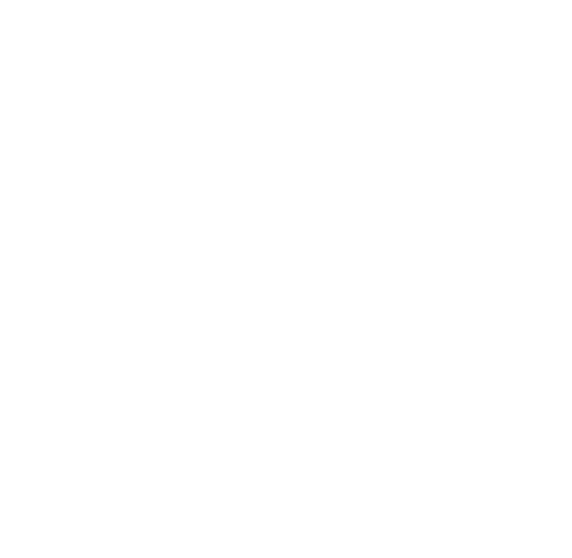

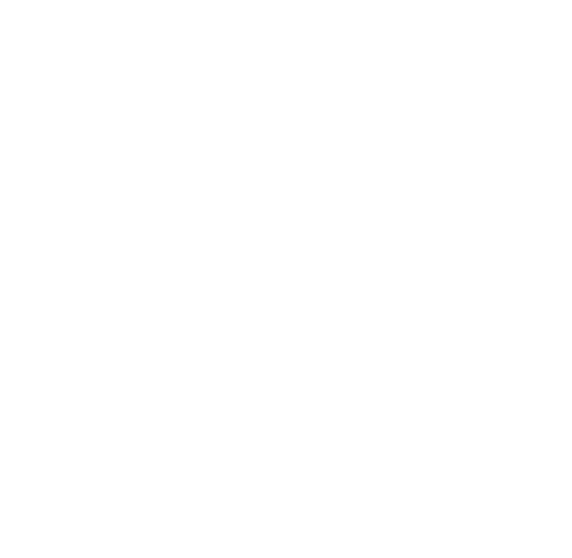

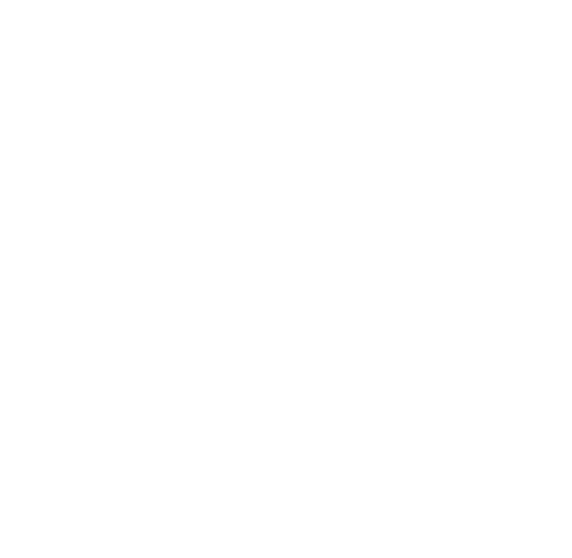

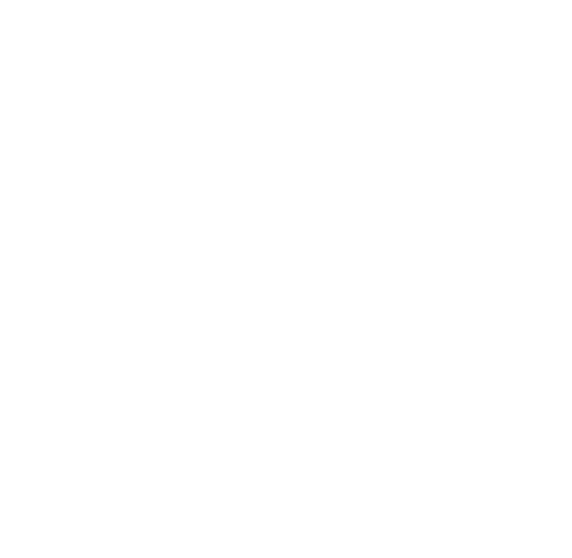

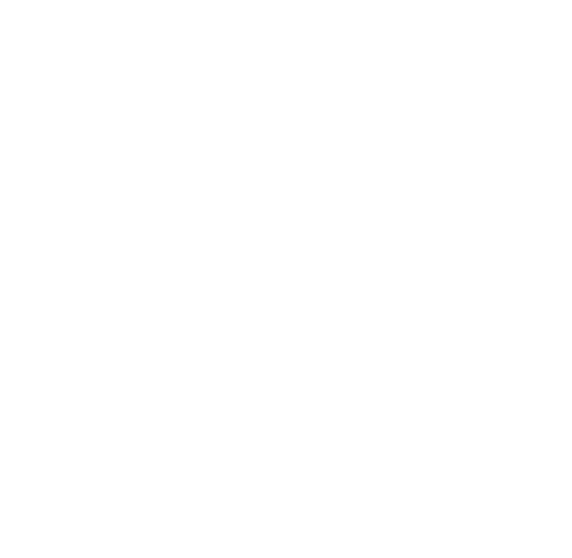

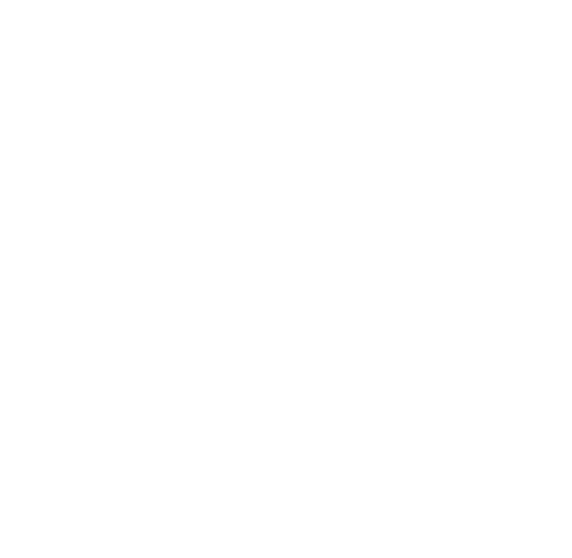

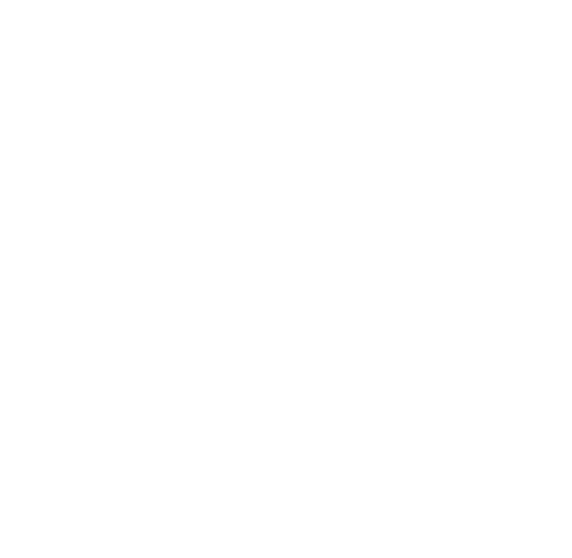

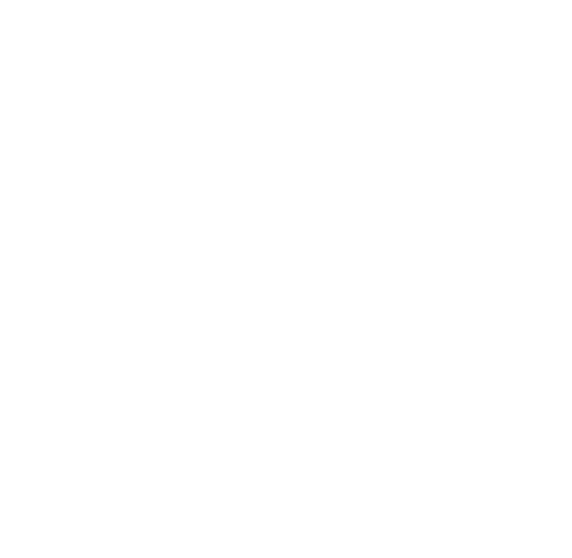

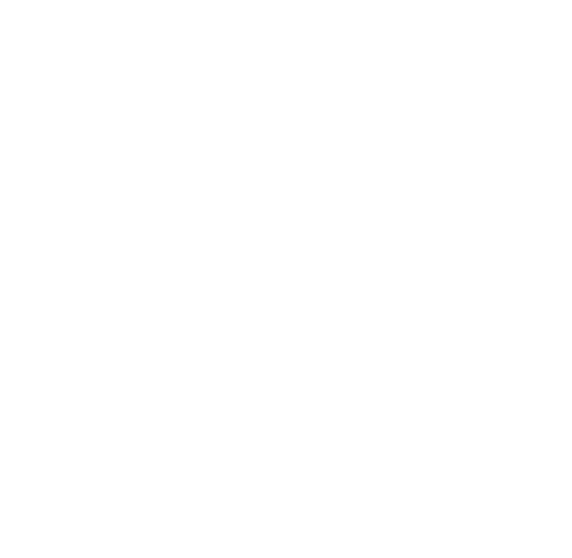

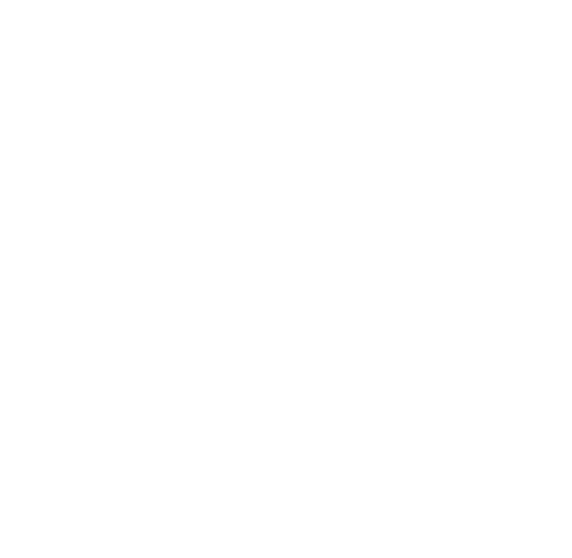

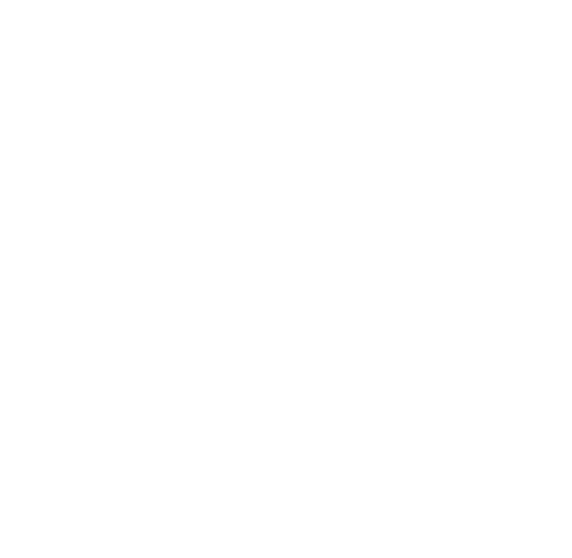

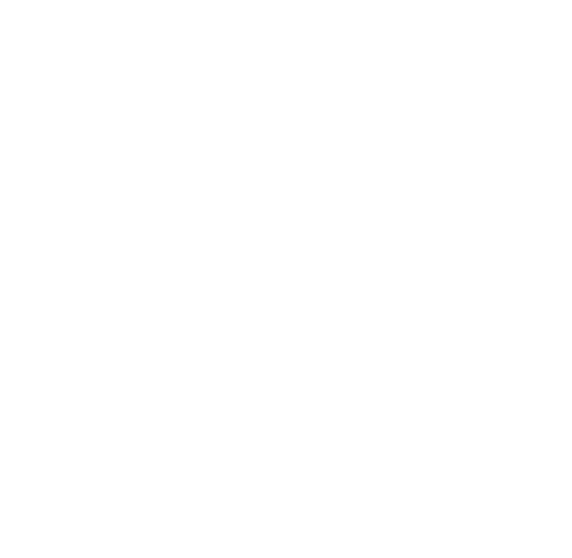

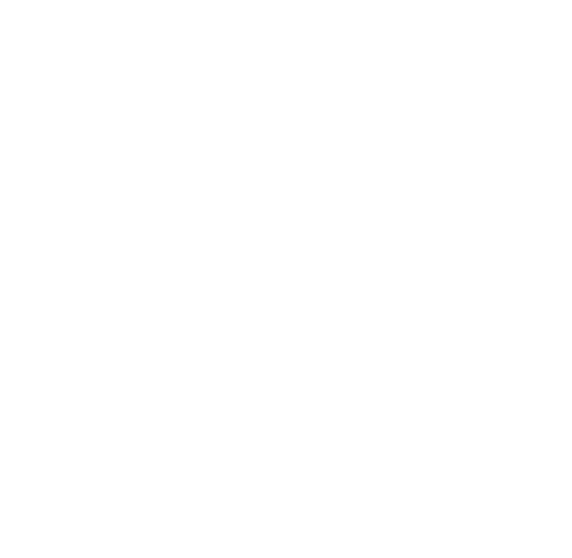

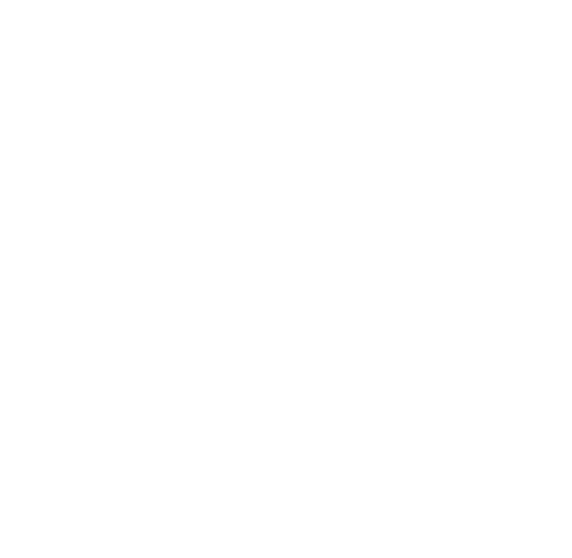

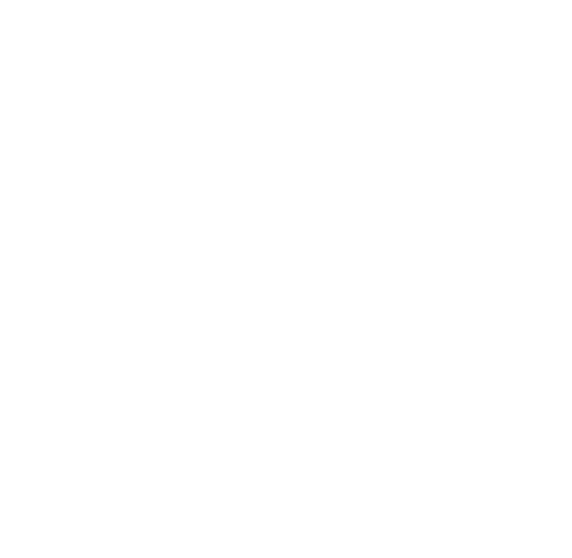

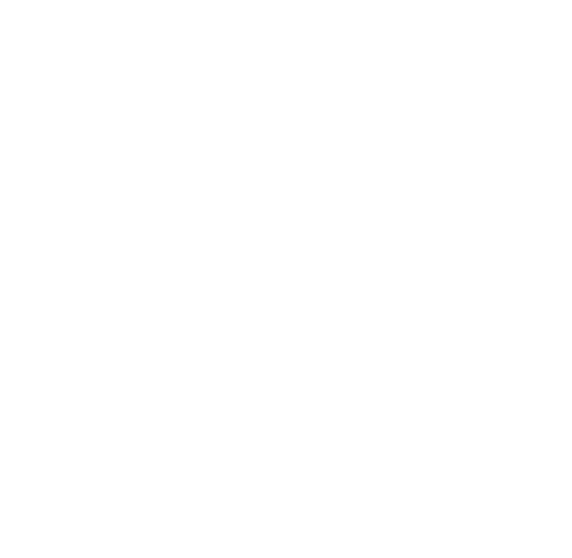

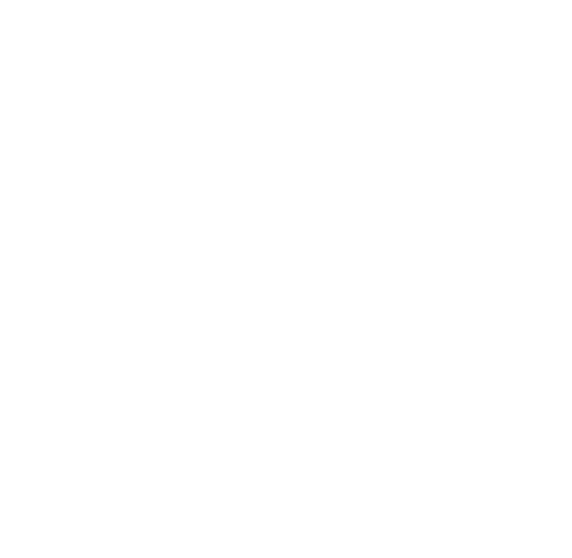

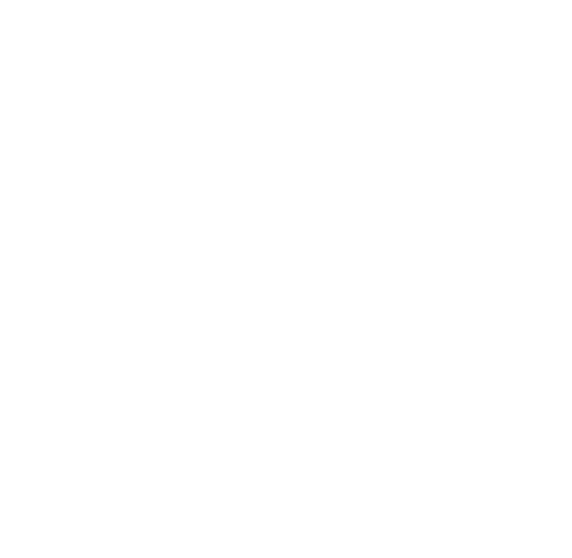

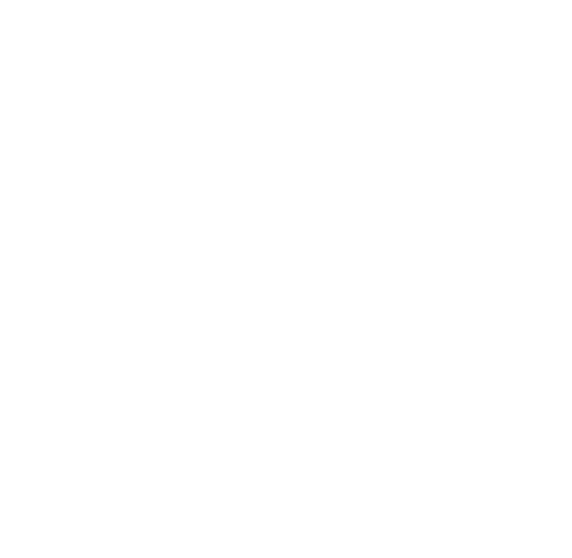

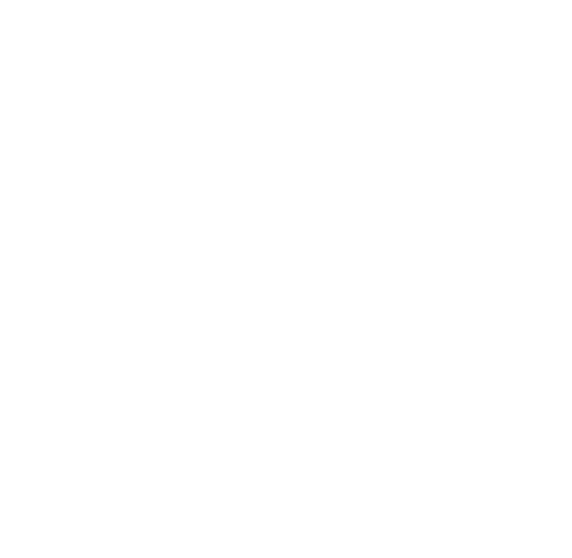

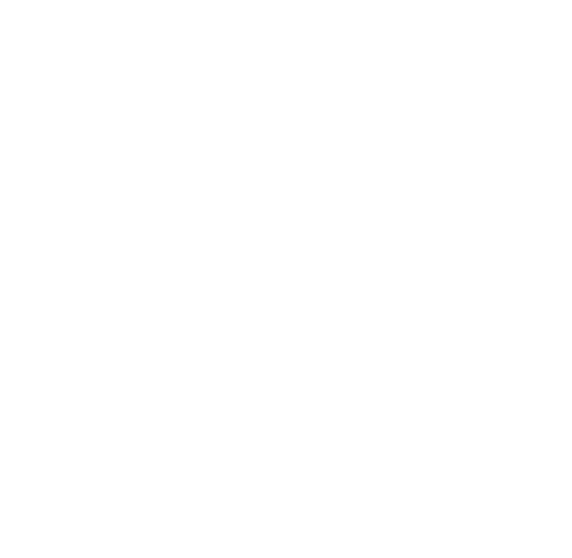

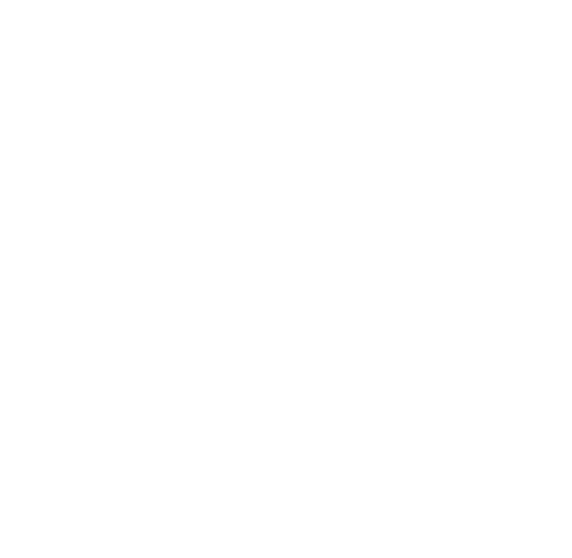

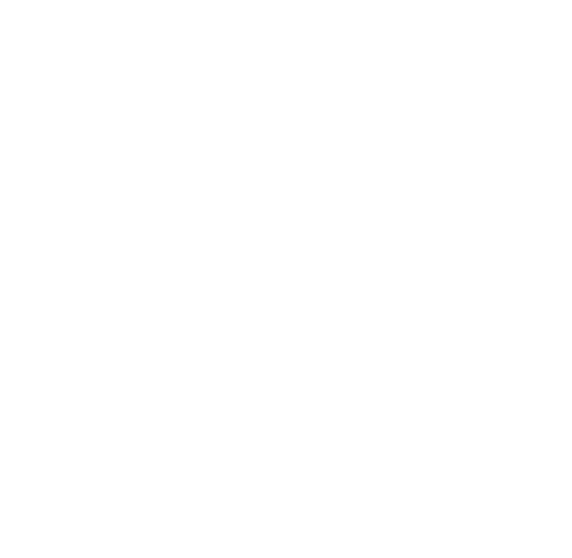

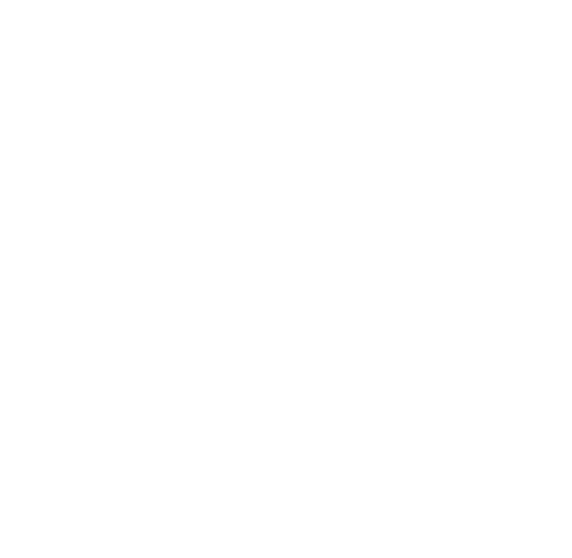

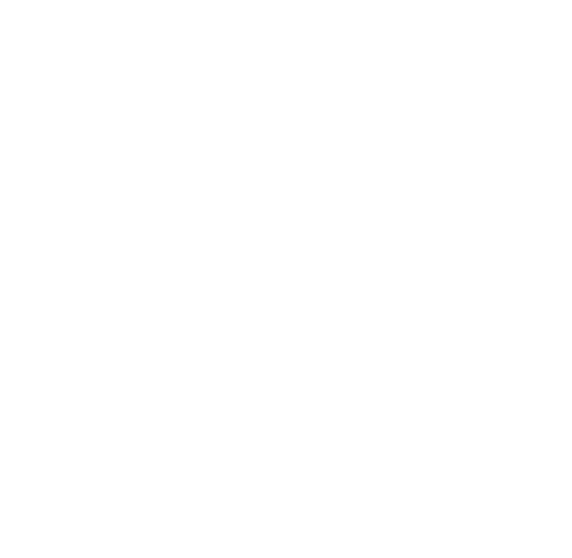

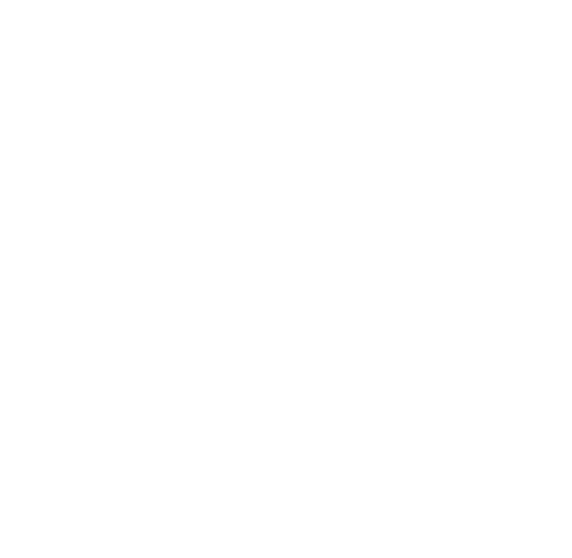

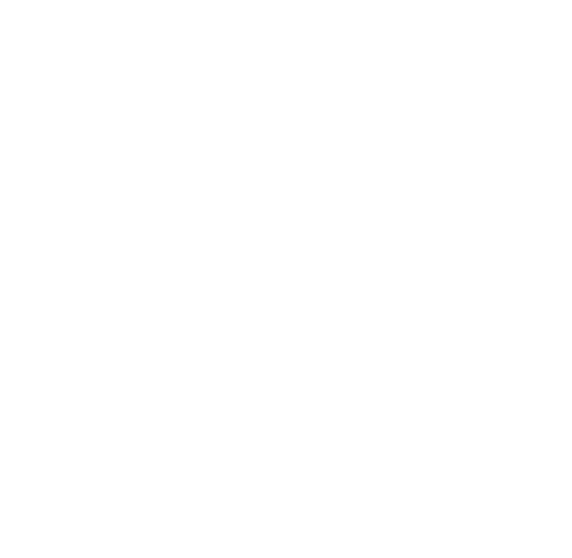

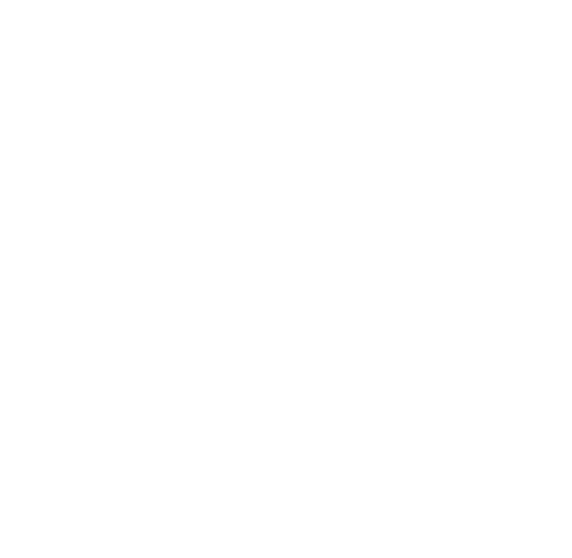

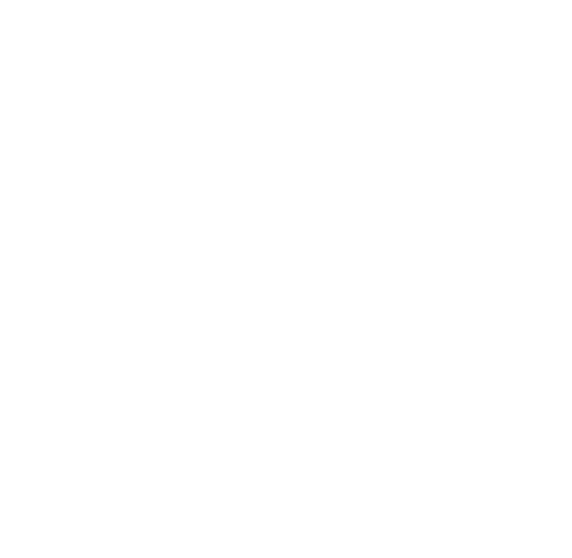

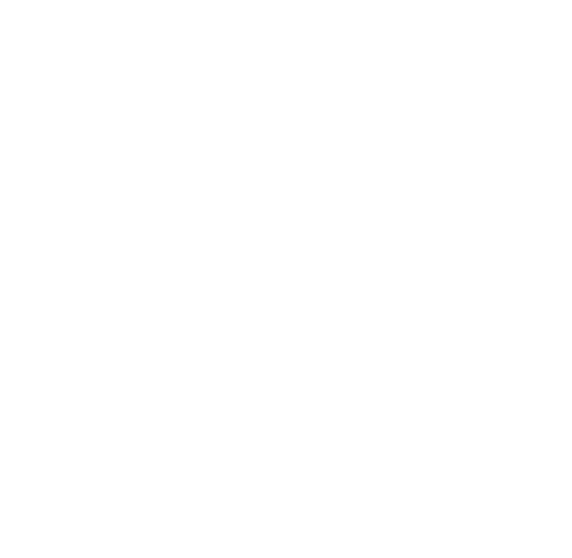

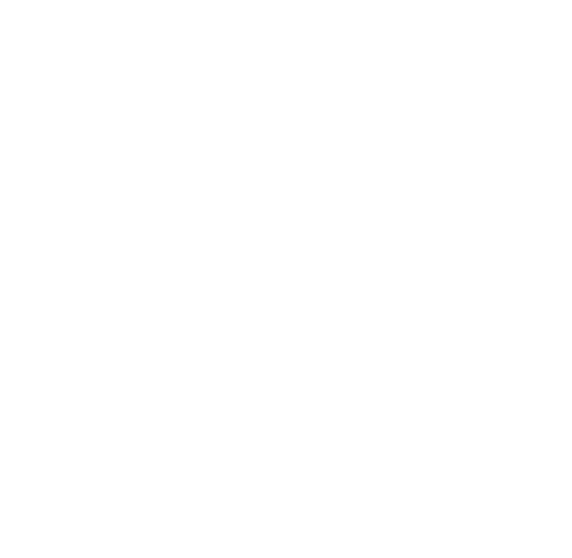

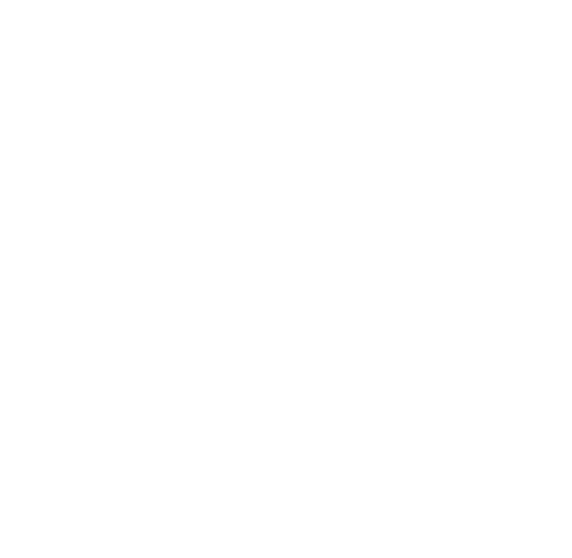

In [28]:
train(normalized_ds, 100)